In [8]:
import  os
import  sys
import  time
import  fitsio
import  timeit
import  importlib
import  numpy.ma            as      ma
import  pylab               as      pl
import  healpy              as      hp
import  numpy               as      np
import  matplotlib.pyplot   as      plt
import  astropy.io.fits     as      fits
import  astropy.units       as      u

from    desiutil            import  dust
from    pkg_resources       import  resource_filename
from    desitarget          import  cuts
from    astropy.table       import  Table, join, hstack, vstack 
from    fast_scatter        import  fast_scatter
from    scipy.stats         import  pearsonr
from    phot_sys            import  set_photsys
from    astropy.coordinates import  SkyCoord

# Montelg

In [9]:
def mag2flux(mag) :
    return 10**(-0.4*(mag-22.5))


In [10]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0)+0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return mag

In [11]:
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)

In [12]:
def normal(seed, size):
    np.random.seed(seed)
    return  np.random.normal(size=size)

In [13]:
target             = 'ELG'
colorcuts_function = cuts.isELG_colors

#  HSC PDR2 with EPHOR redshifts

In [14]:
ephor              = fitsio.read('/global/cscratch1/sd/raichoor/HSC/pdr2.zphot.yeche.ephor.fits', 1)

# Legacy-matched HSC PDR2 

In [15]:
field              = 'w02'  ## [01, ..., 05].

In [16]:
##  DR8 matched Trator catalogues to HSC PDR2. 
_hsc               = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/hsc-pdr2-wide-{}-reduced-match.fits'.format(field), 1)
## _hsc

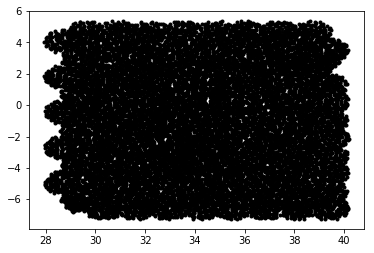

In [17]:
pl.plot(_hsc['ra'][::1000], _hsc['dec'][::1000], c='k', lw=0, marker='.')

In [18]:
##  Line matched legacy catalogue to hsc.
_ls_hsc           = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-hsc-pdr2-wide-{}-reduced-match.fits'.format(field), 1)
##  _ls_hsc

In [19]:
##  Keep only ephor target_ids in this DR8-HSC catalogue.  
common            = np.in1d(ephor['object_id'], _hsc['object_id'])
ncommon           = np.count_nonzero(common)

print(ncommon, len(ephor['object_id']), len(_hsc['object_id']))

6930122 65457870 14344480


In [20]:
ephor             = ephor[common]

In [21]:
ephor             = Table(ephor[:], names=ephor.dtype.names)['object_id', 'ephor_photoz_best']
ephor             = ephor[(0.6 < ephor['ephor_photoz_best']) & (ephor['ephor_photoz_best'] < 1.8)]
##  ephor.pprint()

In [22]:
hsc   = Table(_hsc[:], names=_hsc.dtype.names)
##  hsc.pprint()

In [23]:
ls_hsc = Table(_ls_hsc[:], names=_ls_hsc.dtype.names)
##  ls_hsc.pprint()

In [24]:
hsc = hstack([hsc, ls_hsc])
##  hsc.pprint()

In [25]:
hsc = join(hsc, ephor, join_type='left', keys='object_id')
##  hsc.pprint()

In [26]:
##  truthf = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits'
##  ntruth = fitsio.read('/global/cs/cratch1/sd/mjwilson/BGS/SV-ASSIGN/elgs/hsc_south.fits', 1)

##  for x in ntruth.dtype.names:
##    print(x)

In [27]:
ntruth = hsc

In [28]:
##  ntruth = ntruth[(-1.6 < ntruth['DEC']) & (ntruth['DEC'] < 0.0)]
##  ntruth = ntruth[(21.5 < ntruth['RA'])  & (ntruth['RA']  < 22.5)]

# Apply quality cuts to truth catalogue.

In [29]:
##  Quality photometry cuts.  
ntruth = ntruth[ntruth['ALLMASK_G'] == 0]
ntruth = ntruth[ntruth['ALLMASK_R'] == 0]
ntruth = ntruth[ntruth['ALLMASK_Z'] == 0]

##  Bright star cuts. 
ntruth = ntruth[ntruth['MASKBITS'] & 2**1  == 0]
ntruth = ntruth[ntruth['MASKBITS'] & 2**11 == 0]
ntruth = ntruth[ntruth['MASKBITS'] & 2**12 == 0]
ntruth = ntruth[ntruth['MASKBITS'] & 2**13 == 0]

#  Only matches with an ephor redshift. 

In [30]:
isin   = ~np.array(ntruth.mask['ephor_photoz_best'])
ntruth = ntruth[isin]

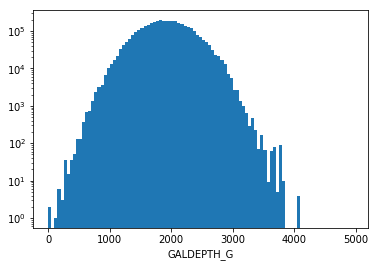

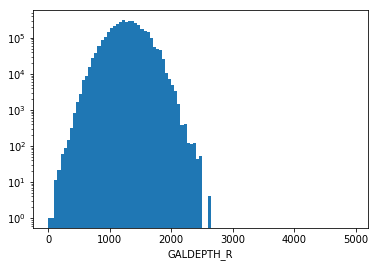

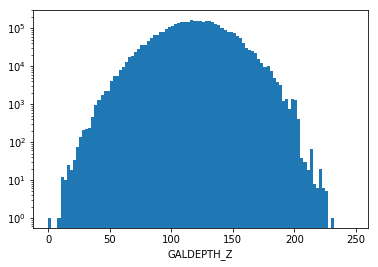

In [31]:
for band, limit in zip(['G', 'R', 'Z'], [5.e3, 5.e3, 2.5e2]):
  _    = pl.hist(ntruth['GALDEPTH_{}'.format(band)], bins=np.arange(0.0, limit, limit / 100.), log=True)
  pl.xlabel('GALDEPTH_{}'.format(band))
  pl.show()  

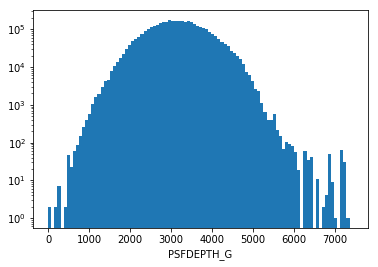

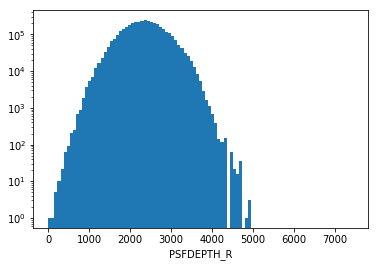

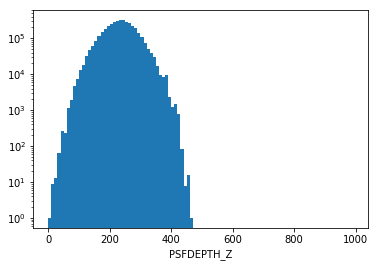

In [32]:
for band, limit in zip(['G', 'R', 'Z'], [7.5e3, 7.5e3, 1.e3]):
  _    = pl.hist(ntruth['PSFDEPTH_{}'.format(band)], bins=np.arange(0.0, limit, limit / 100.), log=True)
  pl.xlabel('PSFDEPTH_{}'.format(band))
  pl.show()  

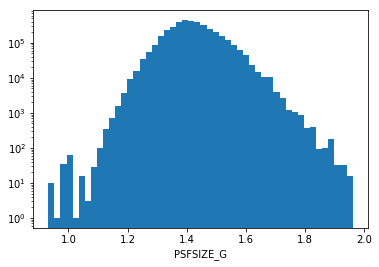

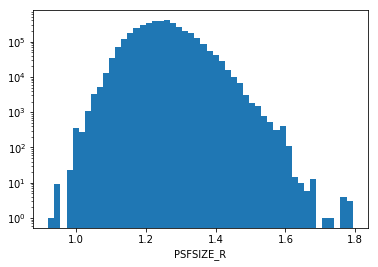

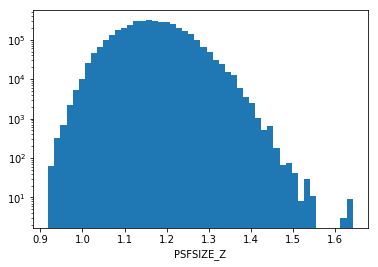

In [33]:
for band in ['G', 'R', 'Z']:
  _    = pl.hist(ntruth['PSFSIZE_{}'.format(band)], bins=50, log=True)
  pl.xlabel('PSFSIZE_{}'.format(band))
  pl.show()  

# Keep those residing in the top 15% of Legacy imaging. 

In [34]:
truth = ntruth

##  Those residing in the 85% deepest imaging in all bands.  
truth = truth[truth['GALDEPTH_G'] >= np.percentile(truth['GALDEPTH_G'], 85)]
truth = truth[truth['GALDEPTH_R'] >= np.percentile(truth['GALDEPTH_R'], 85)]
truth = truth[truth['GALDEPTH_Z'] >= np.percentile(truth['GALDEPTH_Z'], 85)]

In [35]:
len(truth)

12993

In [36]:
ntotal = len(truth)

gflux  = np.array(truth["FLUX_G"] / truth["MW_TRANSMISSION_G"])
rflux  = np.array(truth["FLUX_R"] / truth["MW_TRANSMISSION_R"])
zflux  = np.array(truth["FLUX_Z"] / truth["MW_TRANSMISSION_Z"])

w1flux = np.zeros(gflux.shape)
w2flux = np.zeros(gflux.shape)

gmag   = flux2mag(gflux[:])
rmag   = flux2mag(rflux[:])
zmag   = flux2mag(zflux[:])

mtype  = np.array(truth["TYPE"])
photz  = np.array(truth["ephor_photoz_best"])

##  FWHM = 0.826 * HALF LIGHT RADIUS FOR (ROUND) EXPONENTIAL PROFILE (b1 = 1.678, arXiv:  0503176)  
lscale = 0.826 * np.array(truth["SHAPEEXP_R"])

In [37]:
np.unique(mtype, return_counts=True)

(array([b'COMP', b'DEV ', b'EXP ', b'PSF ', b'REX '], dtype='|S4'),
 array([   5,  455, 1539, 4549, 6445]))

#  Add mag. limits to the truth catalogue. 

In [38]:
standard = (19.0 < gmag) & (19.0 < rmag) & (19.0 < zmag)
standard = standard & (gmag < 25.5) & (rmag < 25.5) & (zmag < 25.5)

print(np.mean(standard.astype(np.float)))

0.8396829061802509


In [39]:
standard = standard & (0.6 < photz) & (photz < 1.4) 

print(np.mean(standard.astype(np.float)))

0.6602786115600708


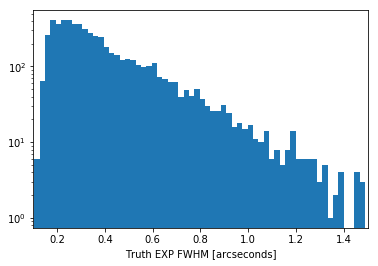

In [40]:
plt.hist(lscale[standard & (lscale > 0.0)], bins=500, log=True)
pl.xlabel('Truth EXP FWHM [arcseconds]')
pl.xlim(0.1, 1.5)
plt.show()

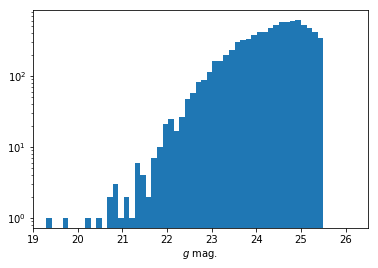

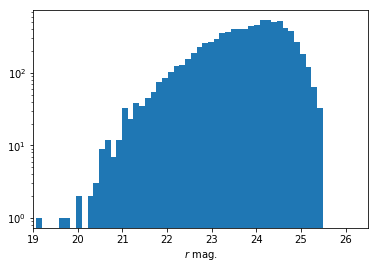

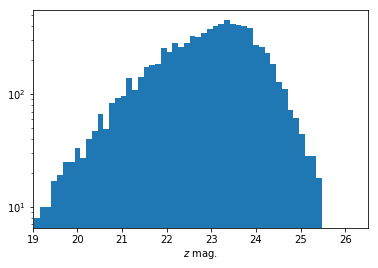

In [41]:
for mag, band in zip([gmag, rmag, zmag], ['g', 'r', 'z']):
  _ = pl.hist(mag[standard], bins=50, log=True)
  pl.xlim(19., 26.5)
  pl.xlabel(r'${}$ mag.'.format(band))
  pl.show()  

In [42]:
##  'FRANKENZ', 'MIZUKIZ' 
toprint            = truth['RA', 'DEC', 'ephor_photoz_best', 'TYPE', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'EBV', 'SHAPEEXP_R']
toprint            = toprint[standard]

toprint.sort('SHAPEEXP_R')
toprint.pprint(max_width=125)

        RA                 DEC         ephor_photoz_best TYPE    FLUX_G     FLUX_R     FLUX_Z       EBV     SHAPEEXP_R
------------------ ------------------- ----------------- ---- ----------- ---------- ---------- ----------- ----------
  39.0629489377698  -6.549663179623504         0.6792196 PSF  0.070907556 0.11147261 0.16232578 0.025662137        0.0
 37.91658212513085  -5.330898487422366        0.64437866 PSF   0.70143944   2.887443  10.329554 0.025546141        0.0
 38.80149562338015  -6.512831180487322        0.96332294 PSF    0.1492831  0.2140612 0.41978842 0.026715588        0.0
 38.78929277349014  -6.513250357068439         1.0141934 PSF   0.12588423 0.10005688 0.14773853 0.026657278        0.0
38.795304221699176  -6.506861233139082        0.85634005 PSF   0.17852186 0.32474348  0.5575092 0.026610281        0.0
37.847912806725525  -5.323988744766423        0.89901555 PSF   0.06215613 0.11463259 0.26541492 0.025621124        0.0
37.884456927494284  -5.332751707278787         1

In [43]:
##  star_selection = ((gmag-rmag)>(1.5*(rmag-zmag)+0.0))
##  star_selection = star_selection & ((gmag-rmag)<(1.5*(rmag-zmag)  + 0.4))
##  star_selection = star_selection & ((gmag-rmag)>(-1.5*(rmag-zmag) + 0.3))
##  star_selection = star_selection & ((gmag-rmag)<(-1.5*(rmag-zmag) + 2.0))

#  Read in DR8 properties map.

In [45]:
pixfn       = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pix, header = fitsio.read(pixfn,header=True)
HPXNSIDE    = header["HPXNSIDE"]

npix        = pix.size

In [46]:
HPXNSIDE

256

In [47]:
select      = (pix["GALDEPTH_G"] > 0) & (pix["GALDEPTH_R"] > 0) & (pix["GALDEPTH_Z"] > 0) & (pix["FRACAREA"] > 0.01)

ii          = np.where(select)[0]

npix        = ii.size

print('{} pixels with ...\n'.format(npix))

for x in pix.dtype.names:
  print(x)

374065 pixels with ...

HPXPIXEL
FRACAREA
STARDENS
EBV
PSFDEPTH_G
PSFDEPTH_R
PSFDEPTH_Z
GALDEPTH_G
GALDEPTH_R
GALDEPTH_Z
PSFDEPTH_W1
PSFDEPTH_W2
PSFSIZE_G
PSFSIZE_R
PSFSIZE_Z
ELG
LRG
QSO
BGS_ANY
MWS_ANY
ALL
STD_FAINT
STD_BRIGHT
LRG_1PASS
LRG_2PASS
BGS_FAINT
BGS_BRIGHT
BGS_WISE
MWS_BROAD
MWS_MAIN_RED
MWS_MAIN_BLUE
MWS_WD
MWS_NEARBY


In [48]:
pix            = pix[ii]

th, phi        = hp.pix2ang(HPXNSIDE, pix['HPXPIXEL'], nest=True)
ra, dec        = thphi2radec(th, phi)

south                                             = np.ones_like(dec, dtype=bool)
south[(dec > 32.375) & (ra > 75.) & (ra < 325.)]  = False

np.unique(south, return_counts=True)

(array([False,  True]), array([ 97069, 276996]))

In [49]:
##  Wrap around.  
ra[ra > 300.] -= 360.
ra            += 60.

ebv            = pix['EBV']

In [50]:
bsee           = np.c_[pix['PSFSIZE_G'], pix['PSFSIZE_R'], pix['PSFSIZE_Z']]

##  Best seeing in any band.
bsee           = bsee.min(axis=1)

print(bsee)

[1.0200208 1.0115045 1.0700233 ... 1.3440142 1.3039014 1.3500899]


In [51]:
g_psfdepth    = -2.5 * np.log10(5. / np.sqrt(pix["PSFDEPTH_G"])) + 22.5
r_psfdepth    = -2.5 * np.log10(5. / np.sqrt(pix["PSFDEPTH_R"])) + 22.5
z_psfdepth    = -2.5 * np.log10(5. / np.sqrt(pix["PSFDEPTH_Z"])) + 22.5

g_galdepth    = -2.5 * np.log10(5. / np.sqrt(pix["GALDEPTH_G"])) + 22.5
r_galdepth    = -2.5 * np.log10(5. / np.sqrt(pix["GALDEPTH_R"])) + 22.5
z_galdepth    = -2.5 * np.log10(5. / np.sqrt(pix["GALDEPTH_Z"])) + 22.5

# Legacy best-fit extinction coefficient
http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients

In [52]:
R_G           = 3.214 
R_R           = 2.165
R_Z           = 1.211

In [53]:
efficiency    = np.zeros(npix)

In [54]:
g_psfsigma    = 1. / np.sqrt(pix["PSFDEPTH_G"])
r_psfsigma    = 1. / np.sqrt(pix["PSFDEPTH_R"])
z_psfsigma    = 1. / np.sqrt(pix["PSFDEPTH_Z"])

g_galsigma    = 1. / np.sqrt(pix["GALDEPTH_G"])
r_galsigma    = 1. / np.sqrt(pix["GALDEPTH_R"])
z_galsigma    = 1. / np.sqrt(pix["GALDEPTH_Z"])

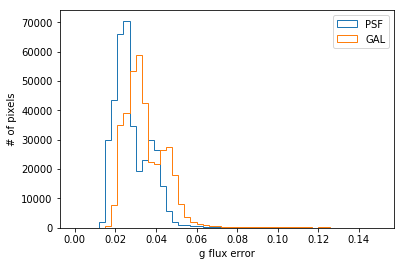

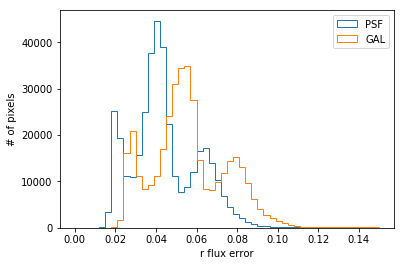

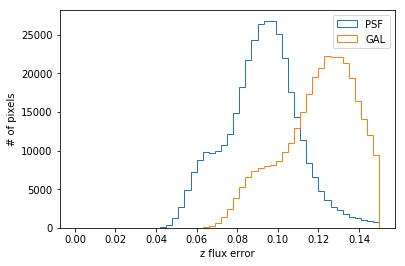

In [55]:
for x, y, z in zip([g_psfsigma, r_psfsigma, z_psfsigma], [g_galsigma, r_galsigma, z_galsigma], ['g', 'r', 'z']):
  plt.hist(x, bins=50, range=(0,.15), histtype='step', label='PSF')
  plt.hist(y, bins=50, range=(0,.15), histtype='step', label='GAL')

  plt.xlabel(r'{} flux error'.format(z))
  plt.ylabel('# of pixels')
  plt.legend()
  plt.show()

# LEGACY SED-MATCHED filter

In [252]:
# https://github.com/legacysurvey/legacypipe/blob/b145769062e86ddfb1979dc3bd5a7307be84afb2/py/legacypipe/detection.py#L332  
sed = {'flat':  [1.0, 1.0, 1.0], 'red': [2.5, 1.0, 0.4]}

def snr_cut(gflux, rflux, zflux, givar, rivar, zivar):
  selection   = np.zeros_like(gflux, dtype=bool)
    
  snr         = {'g':    np.zeros_like(gflux), 'r':   np.zeros_like(rflux), 'z': np.zeros_like(zflux),\
                 'flat': np.zeros_like(gflux), 'red': np.zeros_like(gflux)}

  fluxs       = {'g': gflux, 'r': rflux, 'z': zflux}
  ivars       = {'g': givar, 'r': rivar, 'z': zivar}
    
  for x in ['g', 'r', 'z']:
    snr[x]    = fluxs[x] * np.sqrt(ivars[x])
    selection = selection | (snr[x] >= 6.0)
    
  for x in ['flat', 'red']:
    sedmap    = np.zeros_like(fluxs['g'])
    sediv     = np.zeros_like(fluxs['g']) 
    
    for i, band in enumerate(['g', 'r', 'z']):
      sedmap += fluxs[band] * ivars[band] / sed[x][i]
      sediv  += ivars[band] / sed[x][i]**2

    sedmap   /= np.maximum(1.e-16, sediv)

    snr[x]    = sedmap * np.sqrt(sediv)
    selection = selection | (snr[x] >= 6.0)    
    
  return  np.array(selection), snr 

# (PSF) Magnitude error Monte-Carlo

In [176]:
def ELG_Efficiency(gflux, rflux, zflux, w1flux, w2flux, ispsf, g_psfsig, r_psfsig, z_psfsig, g_galsig, r_galsig, z_galsig, ebv, bseeing,\
                   south=True, printit=False, seed=0, cache=None):
    '''
    Calculate the ELG efficiency for given g, r & z flux uncertainties and a given region's selection.
    '''
    ##  Pass the same seed to generate the same realisation.                
    assert (0 <= seed) & (seed < 64)
   
    if cache is None:
      grand = normal(seed,       gflux.shape)
      rrand = normal(seed + 64,  rflux.shape)
      zrand = normal(seed + 128, zflux.shape)

    else:
      raise  ValueError()
        
    ##  Test Source EXP FWHM against FWHM of MINIMUM PSFSIZE across all bands. 
    ##  rex2psf          = (_mtypes != b'PSF') & (lscale[wz] < bseeing)
    ##  _mtypes[rex2psf] =  b'PSF'
    
    ##  rex2psf      = np.zeros_like(gflux[wz])
    ##  schange      = 100. * np.mean(rex2psf.astype(float)) 
  
    _gext            =  10. ** (-0.4 * R_G * ebv)
    _rext            =  10. ** (-0.4 * R_R * ebv)
    _zext            =  10. ** (-0.4 * R_Z * ebv)

    mgflux           =  _gext * gflux
    mrflux           =  _rext * rflux
    mzflux           =  _zext * zflux
    
    _ispsf           =  ispsf.astype(np.float)

    gsig             =  g_psfsig * _ispsf + g_galsig * (1. - _ispsf)
    rsig             =  r_psfsig * _ispsf + r_galsig * (1. - _ispsf)
    zsig             =  z_psfsig * _ispsf + z_galsig * (1. - _ispsf)

    mgflux          +=  gsig * grand
    mrflux          +=  rsig * rrand
    mzflux          +=  zsig * zrand

    mgivar           =  1. / gsig**2.
    mrivar           =  1. / rsig**2.
    mzivar           =  1. / zsig**2.

    # Desitarget ELG selection:  ADM good S/N in all bands.  
    selection                  = (mgflux > 0.) & (mrflux > 0.) & (mzflux > 0.)
    
    selection[selection], snrs = snr_cut(mgflux[selection], mrflux[selection], mzflux[selection],\
                                         mgivar[selection], mrivar[selection], mzivar[selection])
        
    selection[selection] = colorcuts_function(gflux=mgflux[selection] / _gext, rflux=mrflux[selection] / _rext, zflux=mzflux[selection ]/_zext,\
                                              w1flux=w1flux[selection], w2flux=w2flux[selection], south=south)
    
    eff                  = 100. * np.mean(selection.astype(float))  

    if printit:
      print('{:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:d}'.format(g_psfsig, r_psfsig, z_psfsig,\
                                                                                      ebv, bseeing, eff,\
                                                                                      np.count_nonzero(selection)))
                          
    return  selection, eff, mgflux[selection], mrflux[selection], mzflux[selection]

In [177]:
def ELG_Efficiency_seeds(gflux, rflux, zflux, w1flux, w2flux, ispsf,\
                         g_psfsig, r_psfsig, z_psfsig,\
                         g_galsig, r_galsig, z_galsig,\
                         ebv, bseeing,\
                         south=True, printit=False, seeds=[0]):

  nreal = len(seeds)
    
  eff, gobs, robs, zobs = np.array([]), np.array([]), np.array([]), np.array([])
    
  for seed in seeds:
    _, _mean, _gobs, _robs, _zobs = ELG_Efficiency(gflux, rflux, zflux, w1flux, w2flux, ispsf,\
                                                   g_psfsig, r_psfsig, z_psfsig,\
                                                   g_galsig, r_galsig, z_galsig,\
                                                   ebv, bseeing, south=south,\
                                                   seed=seed, printit=printit)
    
    eff  = np.concatenate([eff, np.array([_mean])])

    gobs = np.concatenate([gobs, _gobs])
    robs = np.concatenate([robs, _robs])
    zobs = np.concatenate([zobs, _zobs])
    
  return  np.mean(eff), np.std(eff), np.std(eff) / np.sqrt(nreal), gobs, robs, zobs

In [178]:
np.count_nonzero(standard)

8579

In [179]:
ispsf = np.array(mtype != b'PSF')
ispsf

array([ True,  True,  True, ...,  True,  True,  True])

In [180]:
##  Over to psf magnitude errors.
ispsf = np.ones_like(ispsf, dtype=bool)

In [181]:
selection, snr = snr_cut(gflux[standard], rflux[standard], zflux[standard], 1./g_psfsigma[0]**2., 1./r_psfsigma[0]**2., 1./z_psfsigma[0]**2.)

In [182]:
np.mean(selection.astype(np.float))

0.9917239771535143

In [189]:
selection, eff, gobs, robs, zobs  = ELG_Efficiency(gflux[standard], rflux[standard], zflux[standard],\
                                                   w1flux[standard], w2flux[standard], ispsf[standard],\
                                                   g_psfsigma[0], r_psfsigma[0], z_psfsigma[0],\
                                                   g_galsigma[0], r_galsigma[0], z_galsigma[0],\
                                                   ebv[0], bsee[0], printit=False, south=south[0],\
                                                   seed=0)

In [190]:
seeds  = np.arange(0, 64, 1)

eff, _, eff_err, gobs, robs, zobs = ELG_Efficiency_seeds(gflux[standard], rflux[standard], zflux[standard],\
                                                         w1flux[standard], w2flux[standard], ispsf[standard],\
                                                         g_psfsigma[0], r_psfsigma[0], z_psfsigma[0],\
                                                         g_galsigma[0], r_galsigma[0], z_galsigma[0],\
                                                         ebv[0], bsee[0], south=south[0], printit=False,\
                                                         seeds = seeds)

In [191]:
eff, eff_err

(4.353290010490733, 0.010182947470496735)

# Monte Carlo flux realisation 

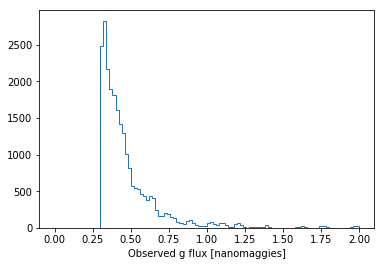

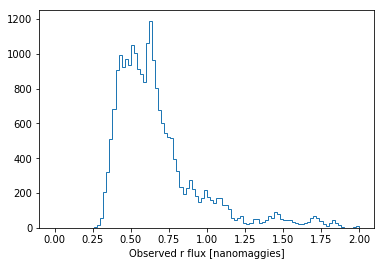

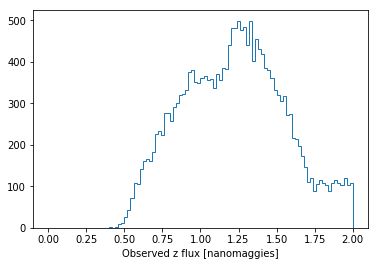

In [56]:
for x, y in zip([gobs, robs, zobs], ['g', 'r', 'z']):
  plt.hist(x, range=(0,2), bins=100, histtype='step')
  plt.xlabel('Observed {} flux [nanomaggies]'.format(y))
  plt.show()

In [57]:
compute = False

if compute:
  tzero = time.time()   
    
  ##  Random sample of pixels. 
  order                     = np.arange(0, npix, 1)

  ##
  np.random.shuffle(order)

  ##  ndo of 374k pixels in pixweight. 
  ndo                       = -1
  todo                      = order[:ndo]
  efficiency                = np.zeros_like(todo, dtype=np.float)
  efficiency_err            = np.zeros_like(todo, dtype=np.float)

  ##  What realisations. 
  seeds                     = np.arange(0, 2, 1)

  gobs                      = []
  robs                      = []
  zobs                      = []

  for count, j in enumerate(todo):                
    eff, _, eff_err, _gobs, _robs, _zobs = ELG_Efficiency_seeds(gflux[standard], rflux[standard], zflux[standard],\
                                                                w1flux[standard], w2flux[standard], ispsf[standard],\
                                                                g_psfsigma[j], r_psfsigma[j], z_psfsigma[j],\
                                                                g_galsigma[j], r_galsigma[j], z_galsigma[j],\
                                                                ebv[j], bsee[j], south=south[j], printit=False,\
                                                                seeds = seeds)
        
    efficiency[count]       = eff
    efficiency_err[count]   = eff_err
    
    gobs.append(_gobs)
    robs.append(_robs)
    zobs.append(_zobs)
    
    ttaken                  = time.time() - tzero
    ttaken                 /= 60.
    
    if count % 7500 == 0: 
      print('{: 5d}/{} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f} \t {:.6f}'.format(count, len(todo), ttaken, g_psfsigma[j], r_psfsigma[j],\
                                                                                                     z_psfsigma[j], ebv[j], bsee[j],\
                                                                                                     efficiency[count]))
    
  np.save('efficiency.npy',    np.c_[todo, efficiency, efficiency_err])

In [58]:
_efficiency        = np.load('efficiency.npy')

todo               = _efficiency[:,0].astype(np.int)
efficiency         = _efficiency[:,1]
efficiency_err     = _efficiency[:,2]

Text(0,0.5,'# pixels')

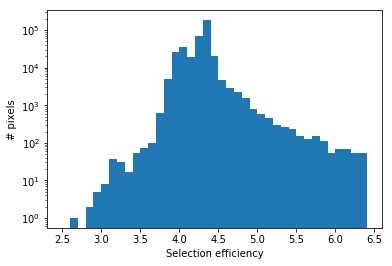

In [59]:
bins               = np.arange(2.5, 6.5, 0.1)
_                  = pl.hist(efficiency, bins=bins,log=True)

pl.xlabel('Selection efficiency')
pl.ylabel('# pixels')

#  DR8 & desi_mask.mask('ELG') > 0.

In [192]:
_elgs = Table(fits.open('/global/cscratch1/sd/mjwilson/BGS/SV-ASSIGN/elgs/elgs.fits')[1].data)
_elgs.pprint()

        RA                 DEC         ...       CHI2DIFF      
------------------ ------------------- ... --------------------
 245.3596393089955  19.196449449148364 ...    0.849112331867218
214.19263826619044   19.80900966088212 ... 0.022419510409235954
208.13960403973084  15.225380563684608 ...    1.239842414855957
233.77243838542103  10.466775335129427 ...    -0.61301189661026
216.54625450649294  19.236846664566702 ...  0.47524401545524597
 233.6157261059142   26.59280671204487 ...  -0.4671635329723358
214.77173550503588   12.95739746918385 ...   0.2556890547275543
213.96152650627442  18.906184462817013 ...   0.9125357270240784
 229.6529759251996   20.52643449065551 ... -0.30007678270339966
 241.1414048787491  14.835225017823378 ...   1.3539882898330688
               ...                 ... ...                  ...
312.60986127168127   -40.8996201075999 ...   5.0644941329956055
 312.7194563352406 -42.937392461445704 ...    5.066047668457031
 310.5592697726102  -43.34000546831893 .

In [193]:
##
os.environ["CSCRATCH"] = "/global/cscratch1/sd/mjwilson"

In [194]:
_elgs['PHOTSYS']                       = 'N'
_elgs['PHOTSYS'][_elgs['DEC'] < 32.375] = 'S'

set_photsys(_elgs, verbose=True)

Loading pre-calculated pixels.


In [195]:
np.unique(_elgs['PHOTSYS'], return_counts=True)

(<Column name='PHOTSYS' dtype='bytes32' length=4>
      BMZLS
 DECALS-NGC
 DECALS-SGC
        DES, array([12890268, 14094848,  9180487, 11090913]))

In [196]:
elgs               = Table(_elgs, copy=True)

In [197]:
len(elgs) / 1.e6

47.256516

In [208]:
nrand              = int(4.5 * len(_elgs))
nrand

212654322

# Randoms

In [209]:
rows               = np.arange(nrand)
_randoms           = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=rows)

In [210]:
keep               = (_randoms['NOBS_G'] > 0) & (_randoms['NOBS_R'] > 0) & (_randoms['NOBS_Z'] > 0)

bitmasks           = [1, 5, 6, 7, 11, 12, 13]

for bit in bitmasks:
  keep            &= ((_randoms['MASKBITS'] & 2**bit)==0)

_erandoms          = _randoms[keep]

In [211]:
_randoms           = Table(_randoms,  names=_randoms.dtype.names)
_erandoms          = Table(_erandoms, names=_erandoms.dtype.names)

##  Rewrite [N,S] photometric system with DECALS-NGC, DECALS-SGC, DES and BMZLS. 

In [212]:
set_photsys(_erandoms, verbose=True)

Loading pre-calculated pixels.


In [213]:
set_photsys(_randoms, verbose=True)

Loading pre-calculated pixels.


In [214]:
_randoms.pprint(max_width=135)

        RA                 DEC         BRICKNAME NOBS_G NOBS_R NOBS_Z ... WISEMASK_W1 WISEMASK_W2     EBV      PHOTSYS   HPXPIXEL
------------------ ------------------- --------- ------ ------ ------ ... ----------- ----------- ----------- ---------- --------
195.25044917965798    26.1081994253917  1951p260      4      4      6 ...           0           0 0.013987649 DECALS-NGC    28125
162.70888411157372 -1.4189722450203919  1626m015      2      3      4 ...           0           0 0.046622634 DECALS-NGC    27022
 187.3132716436337  31.562179883492416  1871p315      3      3      4 ...           0           0  0.01424348 DECALS-NGC    28510
244.23592056146222   76.89002996611195  2442p770      5      4      3 ...           0           0  0.03659907      BMZLS    12110
33.192308859465385   -34.7929915095646  0332m347      6      6      6 ...           0           0 0.012557948        DES    35314
245.67455929137947  27.592205047645475  2456p275      5      5      5 ...           0     

# Legacy SNR cuts. 

In [227]:
dngc_afrac         = np.mean((_erandoms['PHOTSYS'] == 'DECALS-NGC').astype(np.float))
dngc_afrac 

0.2945734636036654

In [228]:
dsgc_afrac         = np.mean((_erandoms['PHOTSYS'] == 'DECALS-SGC').astype(np.float))
dsgc_afrac

0.19765693284592006

In [278]:
selection, snrs       = snr_cut(elgs['FLUX_G'], elgs['FLUX_R'], elgs['FLUX_Z'], elgs['FLUX_IVAR_G'], elgs['FLUX_IVAR_R'], elgs['FLUX_IVAR_Z'])

In [279]:
meets_selections      = np.zeros_like(selection, dtype=np.float)

In [280]:
for _type in ['g', 'r', 'z', 'flat', 'red']:
    meets_selections += (snrs[_type] >= 6.0).astype(np.float)

In [281]:
np.unique(meets_selections, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]),
 array([   10316,    57059,   528344,  5251705,  7332855, 34076237]))

In [287]:
weird = elgs[meets_selections == 0.0]
weird.sort('SNR')
weird.pprint(max_width=-1)

        RA                 DEC         MORPHTYPE DESI_TARGET   FLUX_G      FLUX_R     FLUX_Z   MW_TRANSMISSION_G MW_TRANSMISSION_R MW_TRANSMISSION_Z FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z      TARGETID     GALDEPTH_G GALDEPTH_R GALDEPTH_Z PSFDEPTH_G PSFDEPTH_R PSFDEPTH_Z     EBV        GSNR       RSNR       ZSNR      RZSNR       SNR            BFIT              BFIT2              CHI2DIFF        PHOTSYS  
------------------ ------------------- --------- ----------- ---------- ----------- ---------- ----------------- ----------------- ----------------- ----------- ----------- ----------- ----------------- ---------- ---------- ---------- ---------- ---------- ---------- ----------- ---------- ---------- ---------- ---------- ---------- ------------------ ------------------ -------------------- ----------
171.00161821401286   37.71760354201919       REX         514 0.49832395  0.31377372  0.8253723        0.94311327         0.9613152         0.9781736   1.4382393   0.5723367  0.38160315 351

In [288]:
np.sort(snrs['flat'][meets_selections == 0.0])

<Column name='FLUX_G' dtype='float32' length=10316>
0.78314066
 1.1512083
 1.2587758
 1.2596186
 1.3052073
  1.353755
 1.3793093
 1.4032133
 1.4305398
 1.4410304
  1.445167
 1.4734417
       ...
 5.9993057
 5.9993277
  5.999333
 5.9993362
  5.999409
  5.999426
 5.9995227
 5.9995565
 5.9998026
  5.999912
 5.9999776
 5.9999948

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide


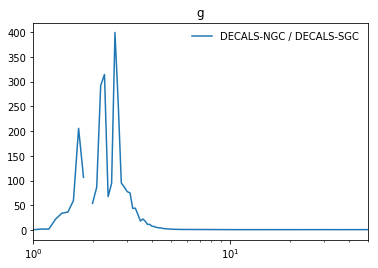

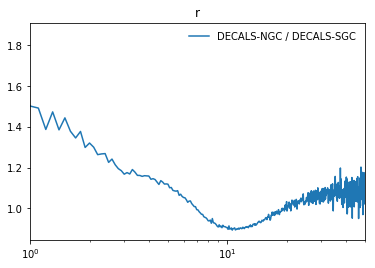

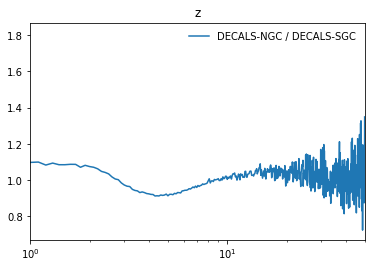

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


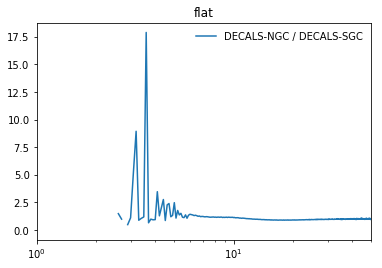

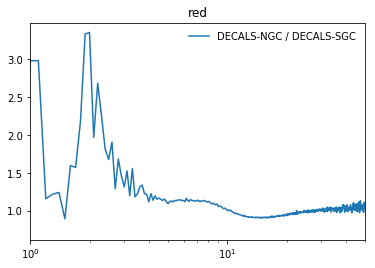

In [246]:
bins                 = np.arange(0., 50., 0.1)

for _type in ['g', 'r', 'z', 'flat', 'red']:
  _nsys              = (elgs['PHOTSYS'] == 'DECALS-NGC')[selection]
  _ssys              = (elgs['PHOTSYS'] == 'DECALS-SGC')[selection]
    
  ngc_cnts, _        = np.histogram(snrs[_type][selection][_nsys], bins=bins)
  sgc_cnts, _        = np.histogram(snrs[_type][selection][_ssys], bins=bins)

  ngc_cnts           = ngc_cnts / dngc_afrac
  sgc_cnts           = sgc_cnts / dsgc_afrac
 
  pl.plot(bins[:-1], sgc_cnts / ngc_cnts, label='DECALS-NGC / DECALS-SGC')

  pl.xlim(1., 50.)  
  pl.xscale('log')
  pl.title(_type)
  pl.legend(frameon=False)
  plt.show()

In [20]:
nside              = 256
parea              = hp.nside2pixarea(nside, degrees = True)

In [ ]:
hppix              = hp.ang2pix(nside, (90. - elgs['DEC']) * np.pi / 180., elgs['RA'] * np.pi / 180., nest=False)
thpind, tcnts      = np.unique(hppix, return_counts=True)

In [76]:
hppix              = hp.ang2pix(nside, (90. - randoms['DEC']) * np.pi / 180., randoms['RA'] * np.pi / 180., nest=False)
rhpind,  rcnts     = np.unique(hppix, return_counts=True)

In [78]:
hppix              = hp.ang2pix(nside, (90. - erandoms['DEC']) * np.pi / 180., erandoms['RA'] * np.pi / 180., nest=False)
erhpind, ercnts    = np.unique(hppix, return_counts=True)

In [75]:
def  process_cnts(ind, cnts, printit=False):
  diff             = np.array(list(set(rhpind) ^ set(ind)))
  
  if printit:
    print(len(rhpind), len(ind), len(diff))
    
  diffout          = np.in1d(diff, ind).astype(bool)
  
  indout           = np.array([x in diff[diffout] for x in ind]).astype(bool)
    
  ind              =  ind[~indout]
  cnts             = cnts[~indout]

  diff             = diff[~diffout]

  isin             = np.in1d(diff, rhpind)  
  diff             = diff[isin]
    
  if len(diff) > 0:
    ind            = np.concatenate([ind, diff])
    cnts           = np.concatenate([cnts,  np.zeros_like(diff)])
    tosort         = np.argsort(ind)
    ind            = ind[tosort]
    cnts           = cnts[tosort]

  return  ind, cnts

In [80]:
erhpind, ercnts        = process_cnts(erhpind, ercnts, printit=False)
thpind, tcnts          = process_cnts(thpind, tcnts, printit=False)

tocorrect              = (rcnts > 0) & (ercnts > 0) 
ctdensity              = tcnts / parea
ctdensity[ercnts == 0] = 0.0

ctdensity[tocorrect]   = tcnts[tocorrect] / parea / (ercnts[tocorrect] / rcnts[tocorrect]) ##  per sq. deg.

In [85]:
theta,phi              = hp.pix2ang(nside, thpind, nest=False)
hpra, hpdec            = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.]     -= 360.
hpra                  += 60.

# Monte Carlo magnitude efficiency map

Text(0,0.5,'Declination [deg.]')

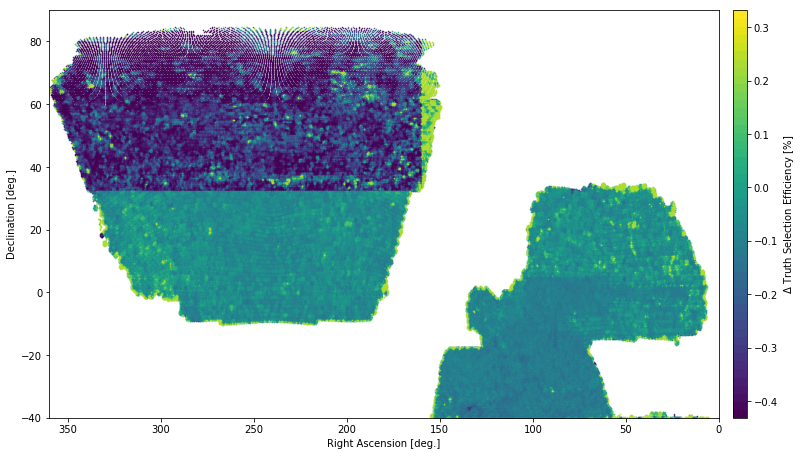

In [86]:
##  plt.style.use('dark_background')

med          = np.median(efficiency[dec[todo] > -40.])
efficiency  -= med

vmin         = np.percentile(efficiency[dec[todo] > -40.],  1)
vmax         = np.percentile(efficiency[dec[todo] > -40.], 99)

fig, ax      = plt.subplots(figsize=(12.5, 7.5))

cb           = fast_scatter(ax, ra[todo], dec[todo], efficiency, vmin, vmax, 50, markersize=1.,\
                            cmap='viridis', printit=False, label=r'$\Delta$ Truth Selection Efficiency [%]')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]', fontsize=10)

# DR8 ELGs

Text(0,0.5,'Declination [deg.]')

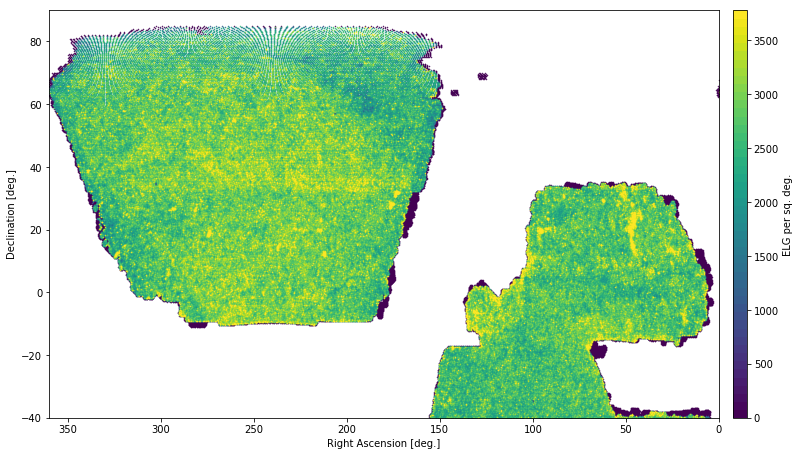

In [87]:
##  plt.style.use('dark_background')

fig, ax      = plt.subplots(figsize=(12.5, 7.5))

vmin         = np.percentile(ctdensity,  1.)
vmax         = np.percentile(ctdensity, 99.)

cb           = fast_scatter(ax, hpra, hpdec, ctdensity, vmin, vmax, 50, markersize=1.,\
                            cmap='viridis', printit=False, label=r'ELG per sq. deg.')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

In [88]:
tosort     = np.argsort(todo)

In [89]:
todo       = todo[tosort]
efficiency = efficiency[tosort]

In [90]:
common     = np.intersect1d(todo, thpind)

In [91]:
isin       = np.in1d(todo, common)

In [92]:
efficiency = efficiency[isin]
todo       = todo[isin]

In [93]:
isin       = np.in1d(thpind, common)

In [94]:
thpind     = thpind[isin]
hpra       = hpra[isin]
hpdec      = hpdec[isin]
ctdensity  = ctdensity[isin]

In [95]:
assert  np.all(np.unique(thpind) == thpind)
assert  np.all(np.unique(todo)   == todo)

In [96]:
pearsonr(efficiency, ctdensity)[0]

-0.04914178350807363

In [21]:
def plot_rel(hg1, hr1, hg2, hr2, hg3, hr3, hg4, hr4, title, quant, taxis=None, maxes=None):
    width = hg1[1][1] - hg1[1][0]
    
    ##  Abscissae as bin midpoints.  
    xl1   = np.array([(hg1[1][i] + hg1[1][i+1])/2. for i in range(len(hg1[0]))])
    xl2   = np.array([(hg2[1][i] + hg2[1][i+1])/2. for i in range(len(hg1[0]))]) + width / 4.
    xl3   = np.array([(hg3[1][i] + hg3[1][i+1])/2. for i in range(len(hg1[0]))]) + width / 2.
    xl4   = np.array([(hg4[1][i] + hg4[1][i+1])/2. for i in range(len(hg1[0]))]) + 3. * width / 4.
    
    ##  Normalise to NELG / NERANDOMS. 
    norm1 = sum(hg1[0])/sum(hr1[0])    
    plt.errorbar(xl1,hg1[0]/hr1[0]/norm1, np.sqrt(hg1[0])/hr1[0]/norm1,fmt='ko')
    
    norm2 = sum(hg2[0])/sum(hr2[0])
    plt.errorbar(xl2,hg2[0]/hr2[0]/norm2, np.sqrt(hg2[0])/hr2[0]/norm2,fmt='rd')
    
    norm3 = sum(hg3[0])/sum(hr3[0])
    plt.errorbar(xl3,hg3[0]/hr3[0]/norm3, np.sqrt(hg3[0])/hr3[0]/norm3,fmt='b^')
    
    norm4 = sum(hg4[0])/sum(hr4[0])
    plt.errorbar(xl4, hg4[0] / hr4[0] / norm4, np.sqrt(hg4[0])/hr4[0]/norm4,fmt='ys')
    
    plt.ylim(.6, 1.5)
    pl.xlim(hg1[1][0], hg1[1][-1])
    
    plt.xlabel(quant , fontsize=14)
    plt.ylabel('Relative Density', fontsize=14)
    
    plt.legend((['BMZLS','DECaLS-NGC','DECaLS-SGC', 'DES']), fontsize=14, frameon=False, loc=3)
    
    pl.axhline(y=1.0, xmin=0., xmax=1., alpha=0.5, c='k')
    pl.fill_between(np.arange(0., 5.e3, 1.2), 0.99, 1.01, color='k', alpha=0.3)
        
    ax           = pl.gca()
    ax.set_title(title + '\n', fontsize=18)

    locs, labels = pl.xticks()
    
    ##
    axx          = ax.twiny()

    axx.set_xlim(ax.get_xlim())
    axx.set_xticks(hg1[1][::5])
    axx.set_xticklabels(['{:.2E}'.format(x) for x in taxis])
    
    if maxes is not None:
      for x, color in zip(maxes, ['k', 'r', 'b', 'y']):
        pl.axvline(x=x, ymin=0., ymax=1., color=color, alpha=0.4)
    
    plt.show()

Solving for BMZLS: PSFDEPTH_G
Solving for DECALS-NGC: PSFDEPTH_G
Solving for DECALS-SGC: PSFDEPTH_G
Solving for DES: PSFDEPTH_G


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2964: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


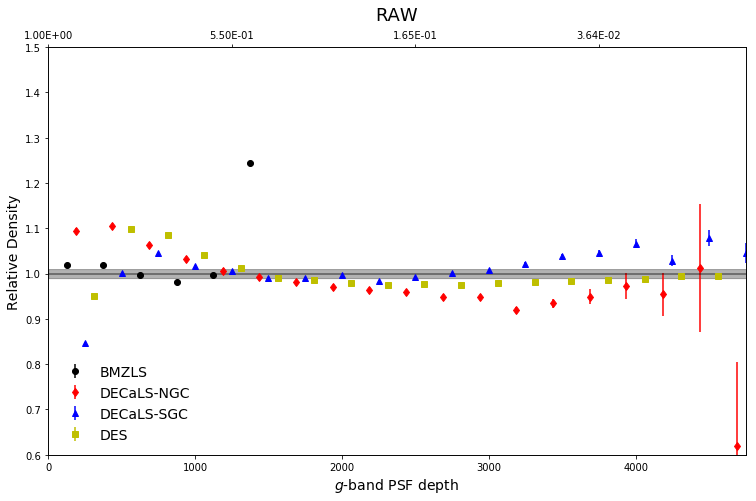

Solving for BMZLS: PSFDEPTH_R
Solving for DECALS-NGC: PSFDEPTH_R
Solving for DECALS-SGC: PSFDEPTH_R
Solving for DES: PSFDEPTH_R


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


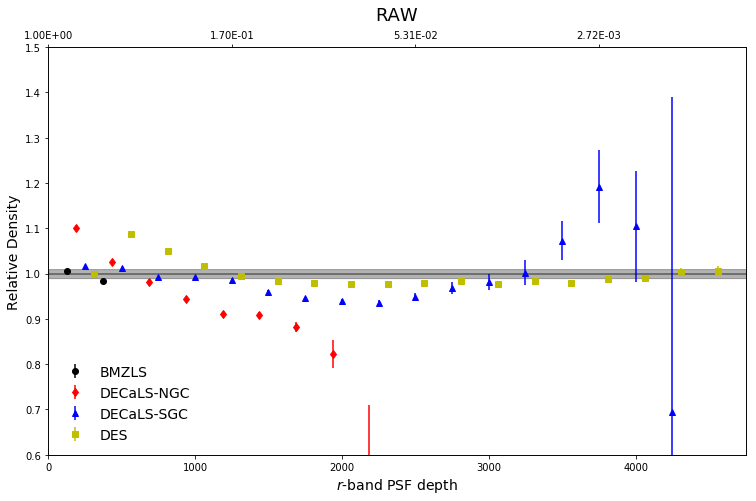

Solving for BMZLS: PSFDEPTH_Z
Solving for DECALS-SGC: PSFDEPTH_Z
Solving for DES: PSFDEPTH_Z


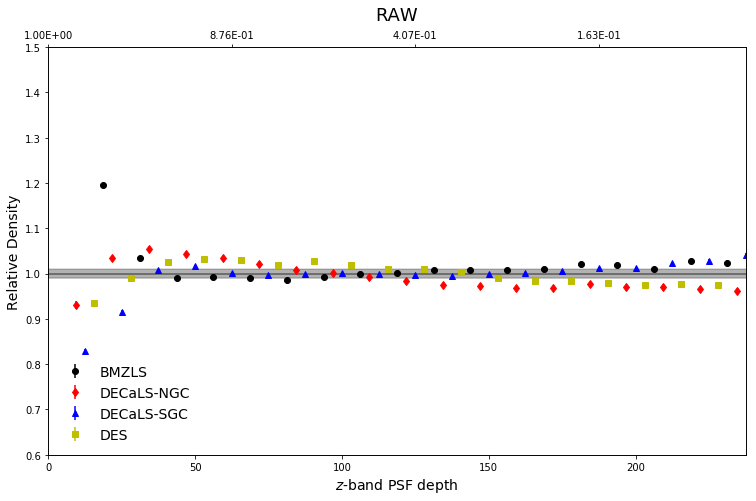

Solving for BMZLS: GALDEPTH_G
Solving for DECALS-NGC: GALDEPTH_G
Solving for DECALS-SGC: GALDEPTH_G
Solving for DES: GALDEPTH_G


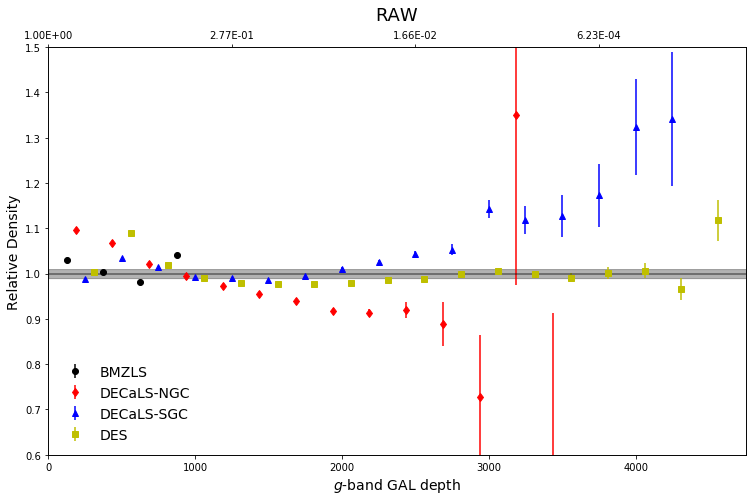

Solving for BMZLS: GALDEPTH_R
Solving for DECALS-NGC: GALDEPTH_R
Solving for DECALS-SGC: GALDEPTH_R
Solving for DES: GALDEPTH_R


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


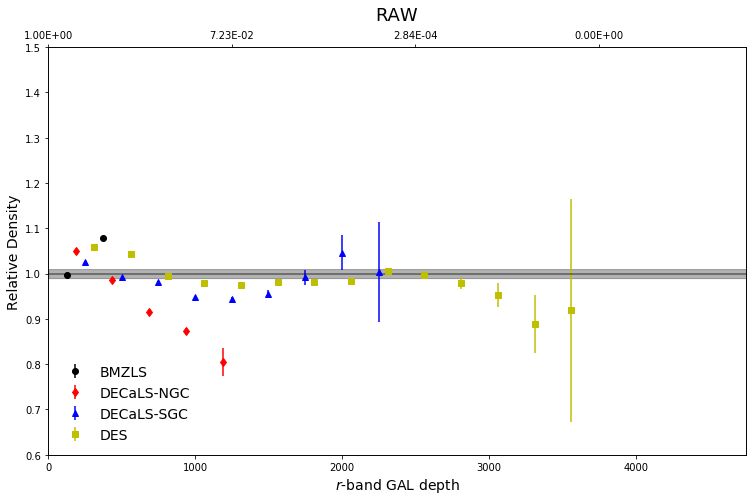

Solving for BMZLS: GALDEPTH_Z
Solving for DECALS-NGC: GALDEPTH_Z
Solving for DECALS-SGC: GALDEPTH_Z
Solving for DES: GALDEPTH_Z


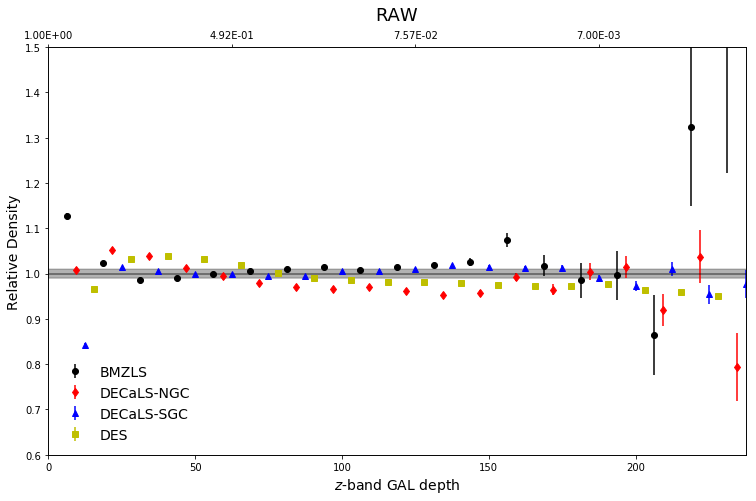

In [27]:
for depth in ['PSF', 'GAL']:
  for band, coeff, limit in zip(['g', 'r', 'z'], [R_G, R_R, R_Z], [5.e3, 5.e3, 2.5e2]):
    key        = '{}DEPTH_{}'.format(depth, band.upper())  
    
    fig, ax    = plt.subplots(figsize=(12.5, 7.5))
    bins       = np.arange(0., limit, limit / 20.)
    
    taxis      = np.array([np.array(erandoms[key] >= x, dtype=np.float).sum() / len(erandoms) for x in bins[::5]])
    
    print('Solving for BMZLS: {}'.format(key))
    
    helg_bmzls = np.histogram(        elgs[elgs['PHOTSYS'] == 'BMZLS'][key]      * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'BMZLS']['EBV']), bins=bins)
    hran_bmzls = np.histogram(erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key]      * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'BMZLS']['EBV']), bins=bins)

    bmzls_max  = erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key].max()
    
    print('Solving for DECALS-NGC: {}'.format(key))
    
    helg_dclsn = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-NGC'][key] * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DECALS-NGC']['EBV']), bins=bins)
    hran_dclsn = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key] * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC']['EBV']), bins=bins)

    dclsn_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key].max()
    
    print('Solving for DECALS-SGC: {}'.format(key))
    
    helg_dclss = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-SGC'][key] * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DECALS-SGC']['EBV']), bins=bins)
    hran_dclss = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key] * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC']['EBV']), bins=bins)

    dclss_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key].max()
    
    print('Solving for DES: {}'.format(key))
    
    helg_des   = np.histogram(        elgs[elgs['PHOTSYS'] == 'DES'][key]        * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DES']['EBV']), bins=bins)
    hran_des   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DES'][key]        * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DES']['EBV']), bins=bins)

    des_max    = erandoms[erandoms['PHOTSYS'] == 'DES'][key].max()
    
    maxes      = [bmzls_max, dclsn_max, dclss_max, des_max]
    maxes      =  None
    
    plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'RAW', r'${}$-band {} depth'.format(band, depth), taxis=taxis, maxes=maxes)

Solving for BMZLS: EBV
Solving for DECALS-NGC: EBV
Solving for DECALS-SGC: EBV
Solving for DES: EBV


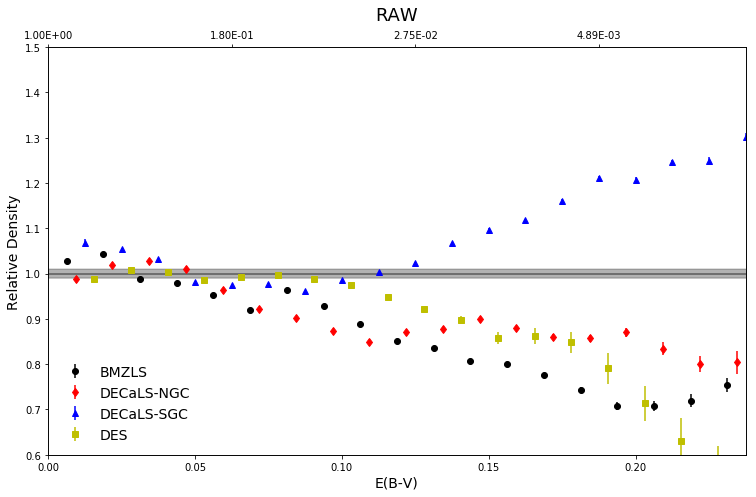

In [28]:
key            = 'EBV'
limit          =  0.25

fig, ax        = plt.subplots(figsize=(12.5, 7.5))
bins           = np.arange(0.0, limit, limit / 20.)
    
taxis          = np.array([np.array(erandoms[key] >= x, dtype=np.float).sum() / len(erandoms) for x in bins[::5]])
    
print('Solving for BMZLS: {}'.format(key))
    
helg_bmzls = np.histogram(        elgs[elgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
hran_bmzls = np.histogram(erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)

bmzls_max  = erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key].max()
    
print('Solving for DECALS-NGC: {}'.format(key))
        
helg_dclsn = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
hran_dclsn = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)

dclsn_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key].max()
    
print('Solving for DECALS-SGC: {}'.format(key))
    
helg_dclss = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
hran_dclss = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)

dclss_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key].max()
    
print('Solving for DES: {}'.format(key))
    
helg_des   = np.histogram(        elgs[elgs['PHOTSYS'] == 'DES'][key], bins=bins)
hran_des   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DES'][key], bins=bins)

des_max    = erandoms[erandoms['PHOTSYS'] == 'DES'][key].max()
    
maxes      = [bmzls_max, dclsn_max, dclss_max, des_max]
maxes      =  None
    
plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'RAW', r'E(B-V)', taxis=taxis, maxes=maxes)

limit          = 2.5  ##  [arcsecond]. 

for band, coeff, limit in zip(['g', 'r', 'z'], [R_G, R_R, R_Z], [5.e3, 5.e3, 2.5e2]):
    key        = 'PSFSIZE_{}'.format(band.upper())  
    
    fig, ax    = plt.subplots(figsize=(12.5, 7.5))
    bins       = np.arange(0., limit, limit / 20.)
    
    taxis      = np.array([np.array(erandoms[key] >= x, dtype=np.float).sum() / len(erandoms) for x in bins[::5]])
    
    print('Solving for BMZLS: {}'.format(key))
    
    helg_bmzls = np.histogram(        elgs[elgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    hran_bmzls = np.histogram(erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)

    bmzls_max  = erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key].max()
    
    print('Solving for DECALS-NGC: {}'.format(key))
    
    helg_dclsn = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    hran_dclsn = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)

    dclsn_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key].max()
    
    print('Solving for DECALS-SGC: {}'.format(key))
    
    helg_dclss = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    hran_dclss = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)

    dclss_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key].max()
    
    print('Solving for DES: {}'.format(key))
    
    helg_des   = np.histogram(        elgs[elgs['PHOTSYS'] == 'DES'][key], bins=bins)
    hran_des   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DES'][key], bins=bins)

    des_max    = erandoms[erandoms['PHOTSYS'] == 'DES'][key].max()
    
    maxes      = [bmzls_max, dclsn_max, dclss_max, des_max]
    maxes      =  None
    
    plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des,\
             'RAW', r'PSFSIZE_{}'.format(band), taxis=taxis, maxes=maxes)


# Total number of objects (by type) after normalisation to same effective area, relative to DES.

In [29]:
for j, survey in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  afrac        = np.mean(np.array(erandoms['PHOTSYS'] == survey).astype(np.float))
  types, cnts  = np.unique(np.array(elgs[elgs['PHOTSYS'] == survey]['MORPHTYPE']), return_counts=True)
  cnts         = np.concatenate([cnts, np.array([cnts.sum()])])  
  cnts         = cnts / afrac
  
  if j == 0:
    norm       = cnts        
    print('\n' + '\t'.join(types.tolist() + ['Total']))

  ncnts        = np.array(cnts) / np.array(norm)
  ncnts        = ['{:.2f}'.format(x) for x in ncnts]
    
  print('\n{} ({:.3f})'.format(survey, afrac))
    
  print('\t'.join(ncnts))


COMP	DEV	EXP	PSF	REX	Total

DES (0.248)
1.00	1.00	1.00	1.00	1.00	1.00

DECALS-SGC (0.198)
0.36	0.59	0.61	1.38	1.23	1.04

DECALS-NGC (0.295)
0.32	0.56	0.65	1.30	1.28	1.07

BMZLS (0.260)
0.11	0.28	0.20	1.29	1.59	1.11


# Limit to E(B-V) < 0.1

In [ ]:
##  elgs       = elgs[elgs['EBV'] < 0.1]
##  erandoms   = erandoms[erandoms['EBV'] < 0.1]

In [ ]:
for j, survey in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  afrac        = np.mean(np.array(erandoms['PHOTSYS'] == survey).astype(np.float))
  types, cnts  = np.unique(np.array(elgs[elgs['PHOTSYS'] == survey]['MORPHTYPE']), return_counts=True)
  cnts         = np.concatenate([cnts, np.array([cnts.sum()])])  
  cnts         = cnts / afrac
  
  if j == 0:
    norm       = cnts        
    print('\n' + '\t'.join(types.tolist() + ['Total']))

  ncnts        = np.array(cnts) / np.array(norm)
  ncnts        = ['{:.2f}'.format(x) for x in ncnts]
    
  print('\n{} ({:.3f})'.format(survey, afrac))
    
  print('\t'.join(ncnts))

In [ ]:
for depth in ['PSF', 'GAL']:
  for band, coeff, limit in zip(['g', 'r', 'z'], [R_G, R_R, R_Z], [5.e3, 5.e3, 2.5e2]):
    key        = '{}DEPTH_{}'.format(depth, band.upper())  
    
    fig, ax    = plt.subplots(figsize=(12.5, 7.5))
    bins       = np.arange(0., limit, limit / 20.)
    
    taxis      = np.array([np.array(erandoms[key] >= x, dtype=np.float).sum() / len(erandoms) for x in bins[::5]])
    
    print('Solving for BMZLS: {}'.format(key))
    
    helg_bmzls = np.histogram(        elgs[elgs['PHOTSYS'] == 'BMZLS'][key]      * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'BMZLS']['EBV']), bins=bins)
    hran_bmzls = np.histogram(erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key]      * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'BMZLS']['EBV']), bins=bins)

    bmzls_max  = erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key].max()
    
    print('Solving for DECALS-NGC: {}'.format(key))
    
    helg_dclsn = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-NGC'][key] * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DECALS-NGC']['EBV']), bins=bins)
    hran_dclsn = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key] * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC']['EBV']), bins=bins)

    dclsn_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key].max()
    
    print('Solving for DECALS-SGC: {}'.format(key))
    
    helg_dclss = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-SGC'][key] * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DECALS-SGC']['EBV']), bins=bins)
    hran_dclss = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key] * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC']['EBV']), bins=bins)

    dclss_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key].max()
    
    print('Solving for DES: {}'.format(key))
    
    helg_des   = np.histogram(        elgs[elgs['PHOTSYS'] == 'DES'][key]        * np.exp(-coeff * elgs[elgs['PHOTSYS']         == 'DES']['EBV']), bins=bins)
    hran_des   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DES'][key]        * np.exp(-coeff * erandoms[erandoms['PHOTSYS'] == 'DES']['EBV']), bins=bins)

    des_max    = erandoms[erandoms['PHOTSYS'] == 'DES'][key].max()
    
    maxes      = [bmzls_max, dclsn_max, dclss_max, des_max]
    maxes      =  None
    
    plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'E(B-V)< 0.1', r'${}$-band {} depth'.format(band, depth), taxis=taxis, maxes=maxes)

# Load Tycho catalogue.

In [30]:
tycho          = Table(fits.open('/global/cscratch1/sd/mjwilson/BGS/SV-ASSIGN/masks/tycho_stellar_mask.fits')[1].data)
tycho.sort('MAG_VT')
tycho

<Table length=2544201>
     RA          DEC       MAG_VT  MRADIUS 
  float64      float64    float32  float32 
------------ ------------ ------- ---------
 95.98787763 -52.69571799  -0.608 471.59998
290.81918193  -6.58466253     0.0 471.59998
110.38858364  25.22952382     0.0 471.59998
289.05124303 -47.27371179     0.0 471.59998
202.33217655 -72.23736948     0.0 471.59998
 77.68021784 -48.45618179     0.0 471.59998
124.43893282 -61.46595001     0.0 471.59998
  0.78080525  29.48484339     0.0 471.59998
154.49938845  17.18677071     0.0 471.59998
204.88499293 -72.50455615     0.0 471.59998
         ...          ...     ...       ...
272.05009028 -39.30062194  12.999 21.341845
299.24131944 -21.61946278  12.999 21.341845
 44.50347028 -26.28843361  12.999 21.341845
295.64648861  12.33455972  12.999 21.341845
126.64943833 -45.89746889  12.999 21.341845
169.44040167  76.14730139  12.999 21.341845
154.50619639 -56.29165917  12.999 21.341845
180.87762583 -15.81274194  12.999 21.341845
280.33990194   7.56551194  12.999 21.341845
235.66629667 -39.03923944  12.999 21.341845

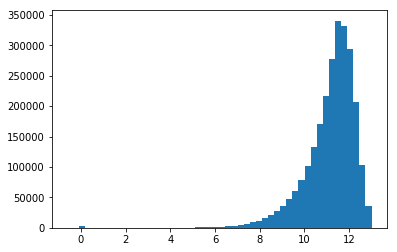

In [32]:
_              = pl.hist(tycho['MAG_VT'], bins=50)

In [31]:
tycho6           =                            tycho[(tycho['MAG_VT'] <  6.)]
tycho10          = tycho[(6.  <= tycho['MAG_VT']) & (tycho['MAG_VT'] < 10.)]
tycho12          = tycho[(10. <= tycho['MAG_VT']) & (tycho['MAG_VT'] < 12.)]

In [ ]:
celgs            = SkyCoord(ra=elgs['RA'] * u.degree, dec= elgs['DEC'] * u.degree)
cerandoms        = SkyCoord(ra=erandoms['RA'] * u.degree, dec= erandoms['DEC'] * u.degree)

# Calculate minimum separation to Tycho star for each ELG in mag. classes.

In [ ]:
for col, cat in zip(['TYCHO6_SEP', 'TYCHO10_SEP', 'TYCHO12_SEP'], [tycho6, tycho10, tycho12]):  
  print('Solving for {}.'.format(col))
  
  ctycho         = SkyCoord(ra=cat['RA'] * u.degree, dec= cat['DEC'] * u.degree)

  idx, d2d, d3d  = celgs.match_to_catalog_sky(ctycho)
  elgs[col]      = d2d

  idx, d2d, d3d  = cerandoms.match_to_catalog_sky(ctycho)
  erandoms[col]  = d2d   

Solving for BMZLS: TYCHO6_SEP
Solving for DECALS-NGC: TYCHO6_SEP
Solving for DECALS-SGC: TYCHO6_SEP
Solving for DES: TYCHO6_SEP


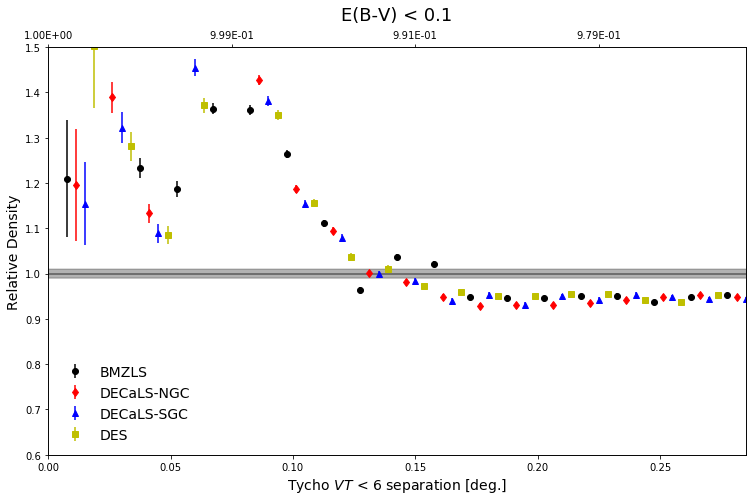

Solving for BMZLS: TYCHO10_SEP
Solving for DECALS-NGC: TYCHO10_SEP
Solving for DECALS-SGC: TYCHO10_SEP
Solving for DES: TYCHO10_SEP


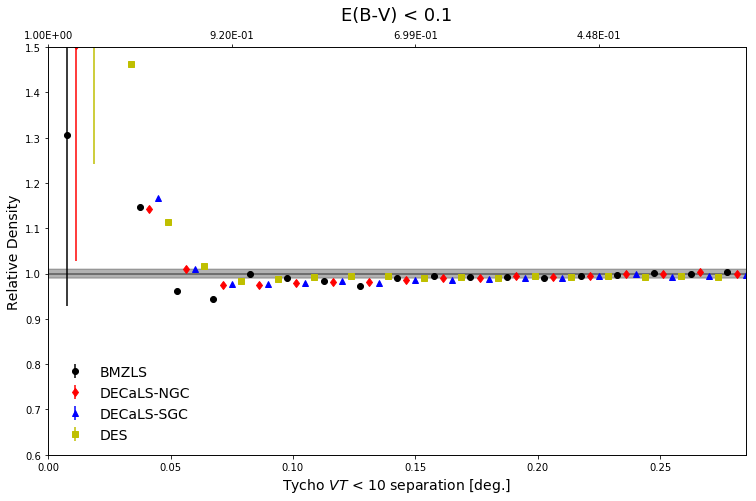

Solving for BMZLS: TYCHO12_SEP
Solving for DECALS-NGC: TYCHO12_SEP
Solving for DECALS-SGC: TYCHO12_SEP
Solving for DES: TYCHO12_SEP


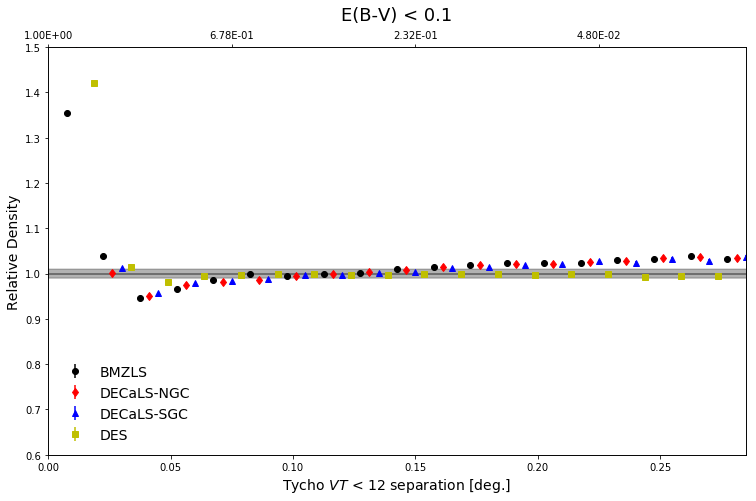

In [35]:
limit            =  0.3

for key, mag in zip(['TYCHO6_SEP', 'TYCHO10_SEP', 'TYCHO12_SEP'], ['6', '10', '12']):
    fig, ax      = plt.subplots(figsize=(12.5, 7.5))
    bins         = np.arange(0.0, limit, limit / 20.)
    
    taxis        = np.array([np.array(erandoms[key] >= x, dtype=np.float).sum() / len(erandoms) for x in bins[::5]])
    
    print('Solving for BMZLS: {}'.format(key))
    
    helg_bmzls   = np.histogram(        elgs[elgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    hran_bmzls   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)

    bmzls_max    = erandoms[erandoms['PHOTSYS'] == 'BMZLS'][key].max()
    
    print('Solving for DECALS-NGC: {}'.format(key))
        
    helg_dclsn = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    hran_dclsn = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)

    dclsn_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-NGC'][key].max()
    
    print('Solving for DECALS-SGC: {}'.format(key))
    
    helg_dclss = np.histogram(        elgs[elgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    hran_dclss = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)

    dclss_max  = erandoms[erandoms['PHOTSYS'] == 'DECALS-SGC'][key].max()
    
    print('Solving for DES: {}'.format(key))
    
    helg_des   = np.histogram(        elgs[elgs['PHOTSYS'] == 'DES'][key], bins=bins)
    hran_des   = np.histogram(erandoms[erandoms['PHOTSYS'] == 'DES'][key], bins=bins)

    des_max    = erandoms[erandoms['PHOTSYS'] == 'DES'][key].max()
    
    maxes      = [bmzls_max, dclsn_max, dclss_max, des_max]
    maxes      =  None
    
    plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'E(B-V) < 0.1', 'Tycho $VT$ < {} separation [deg.]'.format(mag), taxis=taxis, maxes=maxes)

In [52]:
np.mean((erandoms['TYCHO6_SEP'] < 0.17).astype(np.float))

0.01156142594709322

In [53]:
np.mean((erandoms['TYCHO10_SEP'] < 0.075).astype(np.float))

0.07977686531865087

In [54]:
np.mean((erandoms['TYCHO12_SEP'] < 0.075).astype(np.float))

0.3215552044095896

In [63]:
tycho_cut       = (erandoms['TYCHO6_SEP'] < 0.17) | (erandoms['TYCHO10_SEP'] < 0.075) | (erandoms['TYCHO12_SEP'] < 0.075)
np.mean(tycho_cut.astype(np.float))

0.37966132292180227

In [64]:
tycho_cut      = (elgs['TYCHO6_SEP'] < 0.17) | (elgs['TYCHO10_SEP'] < 0.075) | (elgs['TYCHO12_SEP'] < 0.075)
np.mean(tycho_cut.astype(np.float))

0.3827820696726775

#  More conservative Tycho cut

In [ ]:
tycho_cut      = (erandoms['TYCHO6_SEP'] < 0.17) | (erandoms['TYCHO10_SEP'] < 0.075) | (erandoms['TYCHO12_SEP'] < 0.075)
terandoms      =  erandoms[~tycho_cut]

tycho_cut      = (elgs['TYCHO6_SEP'] < 0.17) | (elgs['TYCHO10_SEP'] < 0.075) | (elgs['TYCHO12_SEP'] < 0.075)
telgs          =  elgs[~tycho_cut]

In [66]:
len(telgs) / 1.e6, len(elgs) / 1.e6

(29.167569, 47.256516)

In [67]:
for j, survey in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  afrac        = np.mean(np.array(terandoms['PHOTSYS'] == survey).astype(np.float))
  types, cnts  = np.unique(np.array(telgs[telgs['PHOTSYS'] == survey]['MORPHTYPE']), return_counts=True)
  cnts         = np.concatenate([cnts, np.array([cnts.sum()])])  
  cnts         = cnts / afrac
  
  if j == 0:
    norm       = cnts        
    print('\n' + '\t'.join(types.tolist() + ['Total']))

  ncnts        = np.array(cnts) / np.array(norm)
  ncnts        = ['{:.2f}'.format(x) for x in ncnts]
    
  print('\n{} ({:.3f})'.format(survey, afrac))
    
  print('\t'.join(ncnts))


COMP	DEV	EXP	PSF	REX	Total

DES (0.257)
1.00	1.00	1.00	1.00	1.00	1.00

DECALS-SGC (0.189)
0.34	0.57	0.61	1.39	1.24	1.04

DECALS-NGC (0.304)
0.30	0.54	0.65	1.32	1.30	1.08

BMZLS (0.250)
0.10	0.26	0.20	1.30	1.62	1.12


In [ ]:
hppix                  = hp.ang2pix(nside, (90. - terandoms['DEC']) * np.pi / 180., terandoms['RA'] * np.pi / 180., nest=False)
erhpind, ercnts        = np.unique(hppix, return_counts=True)

hppix                  = hp.ang2pix(nside, (90. - telgs['DEC']) * np.pi / 180., telgs['RA'] * np.pi / 180., nest=False)
hpind, cnts            = np.unique(hppix, return_counts=True)

erhpind, ercnts        = process_cnts(erhpind, ercnts, printit=False)
hpind,   cnts          = process_cnts(hpind, cnts, printit=False)

tocorrect              = (rcnts > 0) & (ercnts > 0) 
ctdensity              = cnts / parea
ctdensity[ercnts == 0] = 0.0

ctdensity[tocorrect]   = cnts[tocorrect] / parea / (ercnts[tocorrect] / rcnts[tocorrect]) ##  per sq. deg.

In [ ]:
nside              = 256
parea              = hp.nside2pixarea(nside, degrees = True)

theta,phi          = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec        = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.] -= 360.
hpra              += 60.

fig, ax            = plt.subplots(figsize=(12.5, 7.5))

vmin               =   20.
vmax               = 5000.

cb                 = fast_scatter(ax, hpra, hpdec, ctdensity, vmin, vmax, 50, markersize=1.,\
                                  cmap='viridis', printit=False, label=r'')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

np.sort(tdensity)

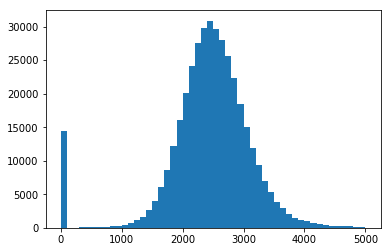

In [113]:
_ = pl.hist(ctdensity, bins=50, range=(0., 5.e3))

Solving for BMZLS: EBV
Solving for DECALS-NGC: EBV
Solving for DECALS-SGC: EBV
Solving for DES: EBV


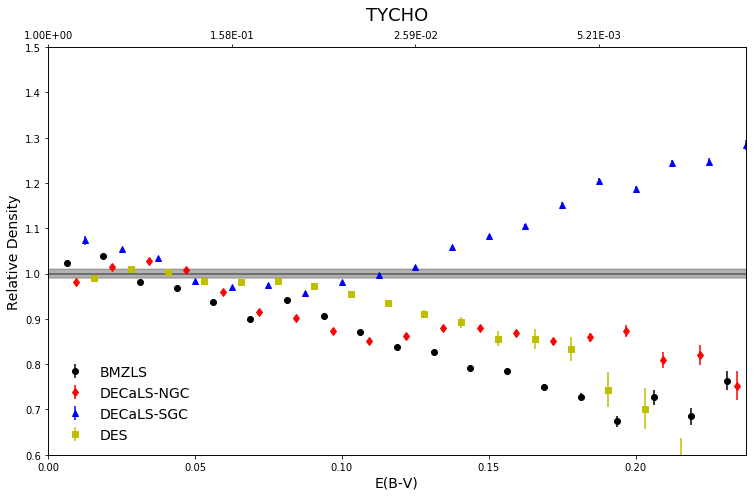

In [70]:
key            = 'EBV'
limit          =  0.25

fig, ax        = plt.subplots(figsize=(12.5, 7.5))
bins           = np.arange(0.0, limit, limit / 20.)
    
taxis          = np.array([np.array(terandoms[key] >= x, dtype=np.float).sum() / len(terandoms) for x in bins[::5]])
    
print('Solving for BMZLS: {}'.format(key))
    
helg_bmzls = np.histogram(        telgs[telgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
hran_bmzls = np.histogram(terandoms[terandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    
print('Solving for DECALS-NGC: {}'.format(key))
        
helg_dclsn = np.histogram(        telgs[telgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
hran_dclsn = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    
print('Solving for DECALS-SGC: {}'.format(key))
    
helg_dclss = np.histogram(        telgs[telgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
hran_dclss = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    
print('Solving for DES: {}'.format(key))
    
helg_des   = np.histogram(        telgs[telgs['PHOTSYS'] == 'DES'][key], bins=bins)
hran_des   = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DES'][key], bins=bins)
        
plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'TYCHO', r'E(B-V)', taxis=taxis, maxes=None)

# Load GAIA catalogue.

In [98]:
gaia           = fitsio.read('/global/cscratch1/sd/mjwilson/BGS/SV-ASSIGN/masks/gaia_stellar_mask.fits')
gaia           = gaia[gaia['ISMEDIUM'] == True]
gaia           = np.c_[gaia['RA'][:], gaia['DEC'][:], gaia['G'][:]]

In [99]:
gaia           = Table(gaia, names=['RA', 'DEC', 'G']) 

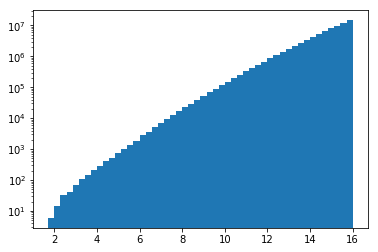

In [100]:
_              = pl.hist(gaia['G'], bins=50, log=True)

In [101]:
gaia10           =                       gaia[(gaia['G'] < 10.)]
gaia12           = gaia[(10. <=  gaia['G']) & (gaia['G'] < 12.)]
gaia14           = gaia[(12. <=  gaia['G']) & (gaia['G'] < 14.)]
gaia16           = gaia[(14. <=  gaia['G']) & (gaia['G'] < 16.)]

In [94]:
ctelgs           = SkyCoord(ra=telgs['RA'] * u.degree, dec= telgs['DEC'] * u.degree)
cterandoms       = SkyCoord(ra=terandoms['RA'] * u.degree, dec= terandoms['DEC'] * u.degree) 

# Calculate minimum separation to GAIA star for each ELG in mag. classes.

In [104]:
for col, cat in zip(['GAIA10_SEP', 'GAIA12_SEP', 'GAIA14_SEP'], [gaia10, gaia12, gaia14]):  
  print('Solving for {}.'.format(col))
  
  cgaia          = SkyCoord(ra=cat['RA'] * u.degree, dec= cat['DEC'] * u.degree)

  idx, d2d, d3d  = ctelgs.match_to_catalog_sky(cgaia)
  telgs[col]     = d2d

  idx, d2d, d3d  = cterandoms.match_to_catalog_sky(cgaia)
  terandoms[col] = d2d

Solving for GAIA10_SEP.
Solving for GAIA12_SEP.
Solving for GAIA14_SEP.


In [118]:
for col, cat in zip(['GAIA16_SEP'], [gaia16]):  
  print('Solving for {}.'.format(col))
  
  cgaia          = SkyCoord(ra=cat['RA'] * u.degree, dec= cat['DEC'] * u.degree)

  idx, d2d, d3d  = ctelgs.match_to_catalog_sky(cgaia)
  telgs[col]     = d2d

  idx, d2d, d3d  = cterandoms.match_to_catalog_sky(cgaia)
  terandoms[col] = d2d

Solving for GAIA16_SEP.


Solving for BMZLS: GAIA10_SEP
Solving for DECALS-NGC: GAIA10_SEP
Solving for DECALS-SGC: GAIA10_SEP
Solving for DES: GAIA10_SEP


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


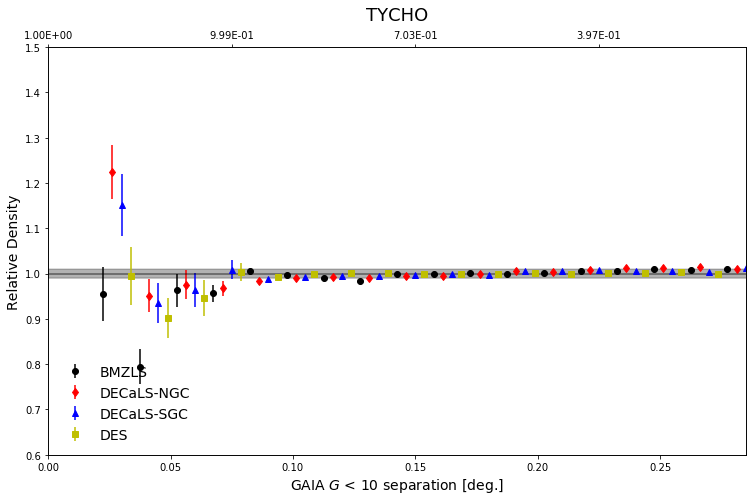

Solving for BMZLS: GAIA12_SEP
Solving for DECALS-NGC: GAIA12_SEP
Solving for DECALS-SGC: GAIA12_SEP
Solving for DES: GAIA12_SEP


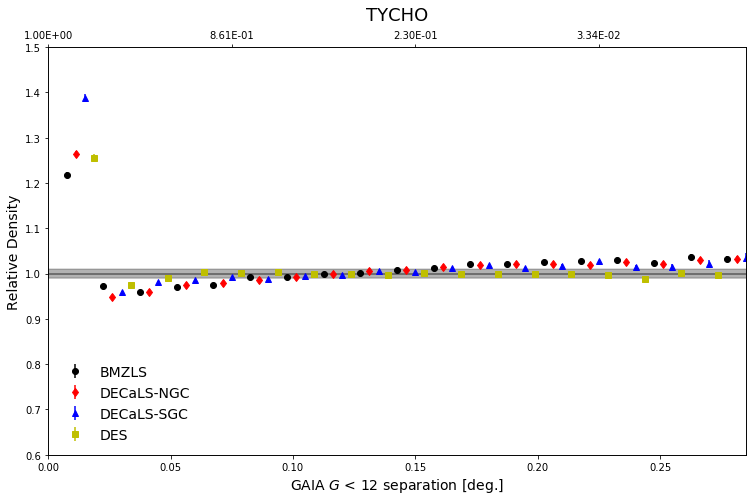

Solving for BMZLS: GAIA14_SEP
Solving for DECALS-NGC: GAIA14_SEP
Solving for DECALS-SGC: GAIA14_SEP
Solving for DES: GAIA14_SEP


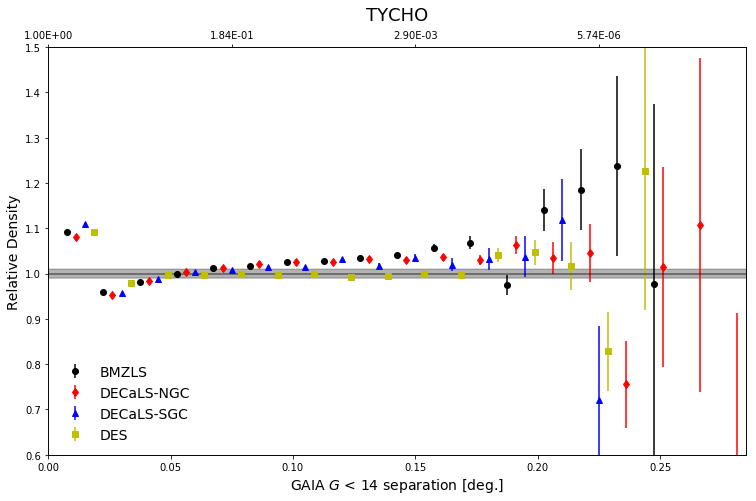

Solving for BMZLS: GAIA16_SEP
Solving for DECALS-NGC: GAIA16_SEP
Solving for DECALS-SGC: GAIA16_SEP
Solving for DES: GAIA16_SEP


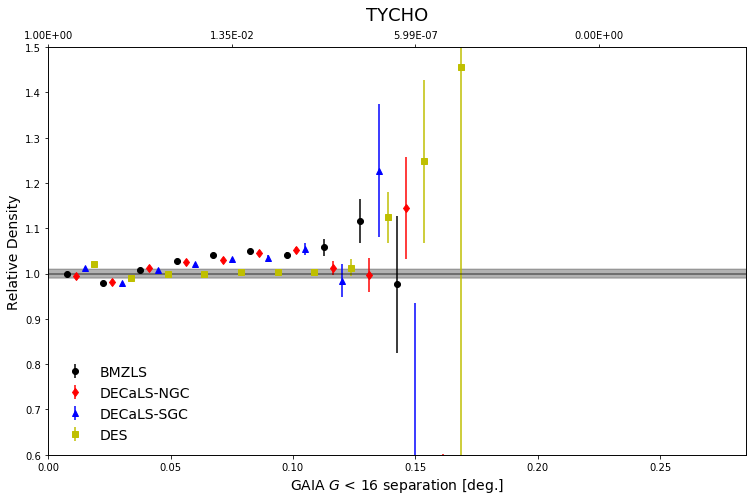

In [119]:
limit            =  0.3

for key, mag in zip(['GAIA10_SEP', 'GAIA12_SEP', 'GAIA14_SEP', 'GAIA16_SEP'], ['10', '12', '14', '16']):
    fig, ax      = plt.subplots(figsize=(12.5, 7.5))
    bins         = np.arange(0.0, limit, limit / 20.)
    
    taxis        = np.array([np.array(terandoms[key] >= x, dtype=np.float).sum() / len(terandoms) for x in bins[::5]])
    
    print('Solving for BMZLS: {}'.format(key))
    
    helg_bmzls   = np.histogram(        telgs[telgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    hran_bmzls   = np.histogram(terandoms[terandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    
    print('Solving for DECALS-NGC: {}'.format(key))
        
    helg_dclsn = np.histogram(        telgs[telgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    hran_dclsn = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    
    print('Solving for DECALS-SGC: {}'.format(key))
    
    helg_dclss = np.histogram(        telgs[telgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    hran_dclss = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    
    print('Solving for DES: {}'.format(key))
    
    helg_des   = np.histogram(        telgs[telgs['PHOTSYS'] == 'DES'][key], bins=bins)
    hran_des   = np.histogram(terandoms[terandoms['PHOTSYS'] == 'DES'][key], bins=bins)
    
    plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'TYCHO', 'GAIA $G$ < {} separation [deg.]'.format(mag), taxis=taxis, maxes=None)

In [ ]:
##  idxc, idxcatalog, d2d, d3d = ctycho.search_around_sky(celgs, 0.1 * u.deg)

# More conservative GAIA cut. 

In [109]:
gaia_cut      = (terandoms['GAIA10_SEP'] < 0.075) | (terandoms['GAIA12_SEP'] < 0.04) | (terandoms['GAIA14_SEP'] < 0.04)
gerandoms     =  terandoms[~gaia_cut]

gaia_cut      = (telgs['GAIA10_SEP'] < 0.075) | (telgs['GAIA12_SEP'] < 0.04) | (telgs['GAIA14_SEP'] < 0.04)
gelgs         =  telgs[~gaia_cut]

In [116]:
len(elgs) / 1.e6, len(telgs) / 1.e6, len(gelgs) / 1.e6

(47.256516, 29.167569, 16.790361)

In [114]:
hppix                  = hp.ang2pix(nside, (90. - gerandoms['DEC']) * np.pi / 180., gerandoms['RA'] * np.pi / 180., nest=False)
erhpind, ercnts        = np.unique(hppix, return_counts=True)

hppix                  = hp.ang2pix(nside, (90. - gelgs['DEC']) * np.pi / 180., gelgs['RA'] * np.pi / 180., nest=False)
hpind, cnts            = np.unique(hppix, return_counts=True)

erhpind, ercnts        = process_cnts(erhpind, ercnts, printit=False)
hpind,   cnts          = process_cnts(hpind, cnts, printit=False)

tocorrect              = (rcnts > 0) & (ercnts > 0) 
ctdensity              = cnts / parea
ctdensity[ercnts == 0] = 0.0

ctdensity[tocorrect]   = cnts[tocorrect] / parea / (ercnts[tocorrect] / rcnts[tocorrect]) ##  per sq. deg.

array([  19.06364964,   19.06364964,   19.06364964, ..., 9112.42452941,
       9264.93372655, 9970.28876335])

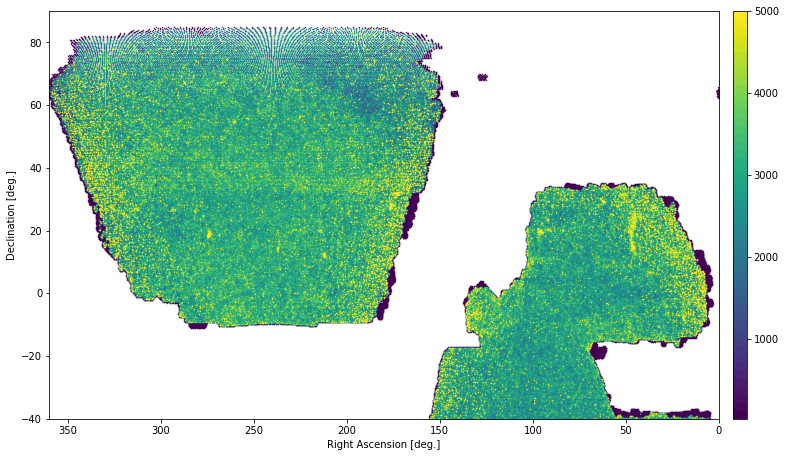

In [115]:
##  hppix              = hp.ang2pix(nside, (90. - gelgs['DEC']) * np.pi / 180., gelgs['RA'] * np.pi / 180., nest=False)
##  hpind, cnts        = np.unique(hppix, return_counts=True)

nside                  = 256
parea                  = hp.nside2pixarea(nside, degrees = True)

theta,phi              = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec            = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.]     -= 360.
hpra                  += 60.

fig, ax                = plt.subplots(figsize=(12.5, 7.5))

vmin                   =   20.
vmax                   = 5000.

cb                     = fast_scatter(ax, hpra, hpdec, ctdensity, vmin, vmax, 50, markersize=1.,\
                                      cmap='viridis', printit=False, label=r'')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

np.sort(tdensity)

Solving for BMZLS: EBV
Solving for DECALS-NGC: EBV
Solving for DECALS-SGC: EBV
Solving for DES: EBV


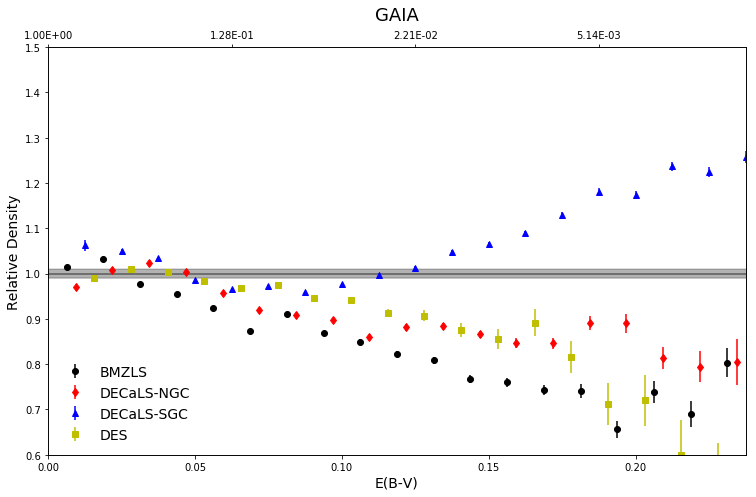

In [117]:
key            = 'EBV'
limit          =  0.25

fig, ax        = plt.subplots(figsize=(12.5, 7.5))
bins           = np.arange(0.0, limit, limit / 20.)
    
taxis          = np.array([np.array(gerandoms[key] >= x, dtype=np.float).sum() / len(gerandoms) for x in bins[::5]])
    
print('Solving for BMZLS: {}'.format(key))
    
helg_bmzls = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
hran_bmzls = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    
print('Solving for DECALS-NGC: {}'.format(key))
        
helg_dclsn = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
hran_dclsn = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    
print('Solving for DECALS-SGC: {}'.format(key))
    
helg_dclss = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
hran_dclss = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    
print('Solving for DES: {}'.format(key))
    
helg_des   = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DES'][key], bins=bins)
hran_des   = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DES'][key], bins=bins)
        
plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'GAIA', r'E(B-V)', taxis=taxis, maxes=None)

In [287]:
for j, survey in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  afrac        = np.mean(np.array(gerandoms['PHOTSYS'] == survey).astype(np.float))
  types, cnts  = np.unique(np.array(gelgs[gelgs['PHOTSYS'] == survey]['MORPHTYPE']), return_counts=True)
  cnts         = np.concatenate([cnts, np.array([cnts.sum()])])  
  cnts         = cnts / afrac
  
  if j == 0:
    norm       = cnts        
    print('\n' + '\t'.join(types.tolist() + ['Total']))

  ncnts        = np.array(cnts) / np.array(norm)
  ncnts        = ['{:.2f}'.format(x) for x in ncnts]
    
  print('\n{} ({:.3f}, {:.2f})'.format(survey, afrac, np.sum(np.array(cnts) / 1.e6)))
    
  print('\t'.join(ncnts))


COMP	DEV	EXP	PSF	REX	Total

DES (0.268, 31.42)
1.00	1.00	1.00	1.00	1.00	1.00

DECALS-SGC (0.172, 32.90)
0.32	0.56	0.61	1.40	1.26	1.05

DECALS-NGC (0.314, 34.27)
0.28	0.54	0.65	1.34	1.33	1.09

BMZLS (0.246, 35.54)
0.09	0.25	0.20	1.32	1.66	1.13


# Write viewer files.

In [159]:
for hsphere in ['NGC', 'SGC']:
  toview = gelgs['RA', 'DEC', 'PHOTSYS']
  toview = toview[toview['PHOTSYS'] == 'DECALS-{}'.format(hsphere)]

  del toview['PHOTSYS']

  toview           = toview[::100]
  toview['radius'] = 1.6

  toview.write('toview_{}.fits'.format(hsphere), format='fits', overwrite=True)

In [286]:
toview = gelgs['RA', 'DEC', 'EBV']
toview = toview[toview['EBV'] > 0.1]

toview = toview[::100]
toview['radius'] = 1.6

toview.write('toview.fits', format='fits', overwrite=True)

len(toview)

7119

In [157]:
for cat in [gelgs, gerandoms]:
  s            = SkyCoord(ra=cat['RA'] * u.degree, dec=cat['DEC'] * u.degree,frame='icrs')
  s_gal        = s.galactic
  cat['GLON']  = s_gal.l.value
  cat['GLAT']  = np.abs(s_gal.b.value)

Solving for BMZLS: GLAT
Solving for DECALS-NGC: GLAT
Solving for DECALS-SGC: GLAT
Solving for DES: GLAT


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


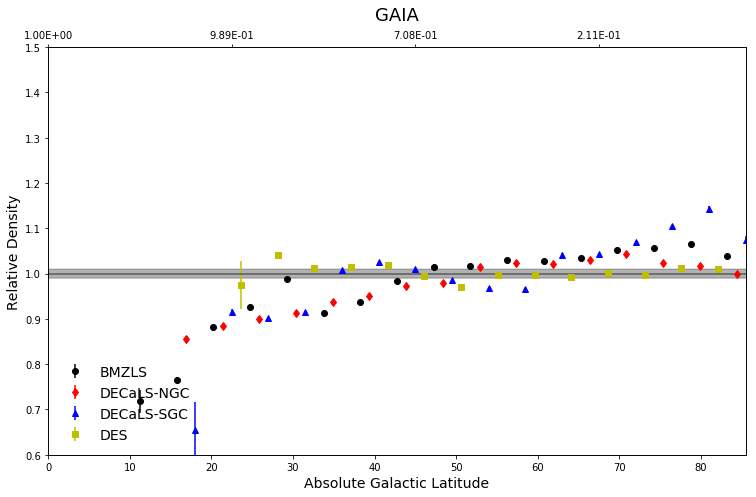

In [158]:
key            = 'GLAT'
limit          =  90.

fig, ax        =  plt.subplots(figsize=(12.5, 7.5))
bins           =  np.arange(0., limit, limit / 20.)
    
taxis          =  np.array([np.array(gerandoms[key] >= x, dtype=np.float).sum() / len(gerandoms) for x in bins[::5]])
    
print('Solving for BMZLS: {}'.format(key))
    
helg_bmzls = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
hran_bmzls = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    
print('Solving for DECALS-NGC: {}'.format(key))
        
helg_dclsn = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
hran_dclsn = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    
print('Solving for DECALS-SGC: {}'.format(key))
    
helg_dclss = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
hran_dclss = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    
print('Solving for DES: {}'.format(key))
    
helg_des   = np.histogram(        gelgs[gelgs['PHOTSYS'] == 'DES'][key], bins=bins)
hran_des   = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DES'][key], bins=bins)
        
plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'GAIA', r'Absolute Galactic Latitude', taxis=taxis, maxes=None)

BMZLS           17.768
DECALS-NGC      17.133
DECALS-SGC      16.449
DES             15.709


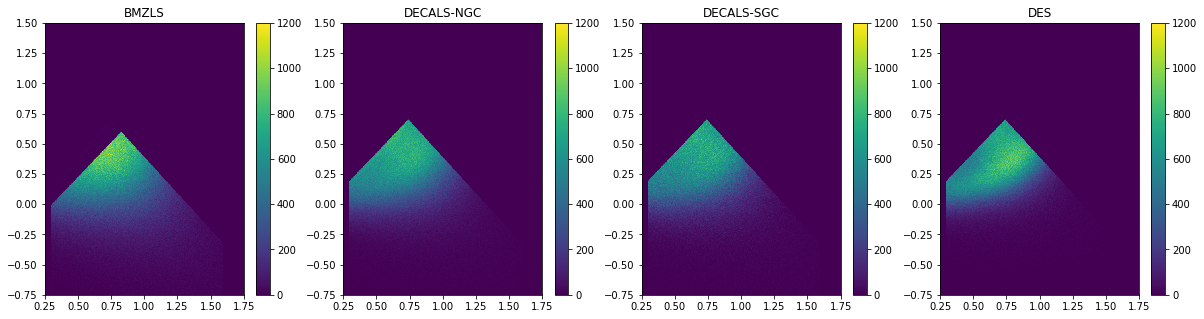

In [290]:
fig, ax  = plt.subplots(1, 4, figsize=(20.5, 5.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

for i, photsys in enumerate(['BMZLS', 'DECALS-NGC', 'DECALS-SGC', 'DES']):
  cat    = gelgs[gelgs['PHOTSYS'] == photsys]
    
  g      = 22.5 - 2.5 * np.log10((cat['FLUX_G'] / cat['MW_TRANSMISSION_G']).clip(1.e-16))
  r      = 22.5 - 2.5 * np.log10((cat['FLUX_R'] / cat['MW_TRANSMISSION_R']).clip(1.e-16))
  z      = 22.5 - 2.5 * np.log10((cat['FLUX_Z'] / cat['MW_TRANSMISSION_Z']).clip(1.e-16))
  
  afrac  = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))

  h, xedges, yedges = np.histogram2d(r-z, g-r, bins=500, range=[[0.25, 1.75], [-0.75, 1.5]])

  h      = h.T  
  h     /= afrac 
    
  X, Y   = np.meshgrid(xedges, yedges)
    
  hb     = ax[i].pcolormesh(X, Y, h, vmin=0.0, vmax=1200.)  
  cb     = fig.colorbar(hb, ax=ax[i])

  ax[i].axis([0.25, 1.75, -0.75, 1.5])
  ax[i].set_title(photsys)
    
  print(photsys.ljust(15), '{:.3f}'.format(len(cat) / afrac / 1.e6))

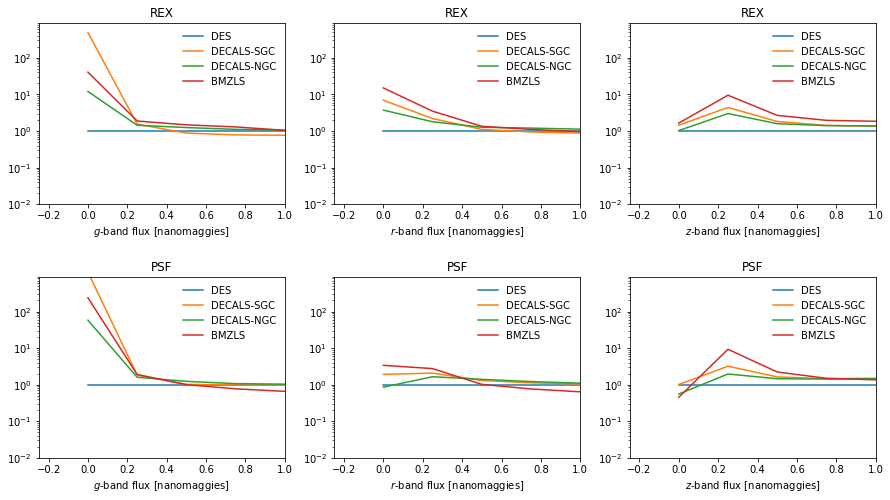

In [376]:
bins            = np.arange(0.0, 10., 0.25) 
fig, ax         = plt.subplots(2, 3, figsize=(15.0, 8.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

for k, mtype in enumerate(['REX', 'PSF']):
  for j, band in enumerate(['G', 'R', 'Z']):
    for i, photsys in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
      cat       = gelgs[gelgs['PHOTSYS'] == photsys]  
      cat       = cat[cat['MORPHTYPE']   == mtype]
    
      afrac     = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))
 
      h, xedges = np.histogram(cat['FLUX_{}'.format(band)], bins=bins)

      h         = np.array(h) / afrac 
    
      if i == 0:
        norm    = h    
    
      hb        = ax[k][j].semilogy(xedges[:-1], h / norm, label=photsys)  

    ax[k][j].set_xlim(-0.25, 1.0)  
    ax[k][j].set_ylim(0.01, 9.e2)
    ax[k][j].set_xlabel(r'${}$-band flux [nanomaggies]'.format(band.lower()))  
    ax[k][j].set_title(mtype)
    ax[k][j].legend(frameon=False)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


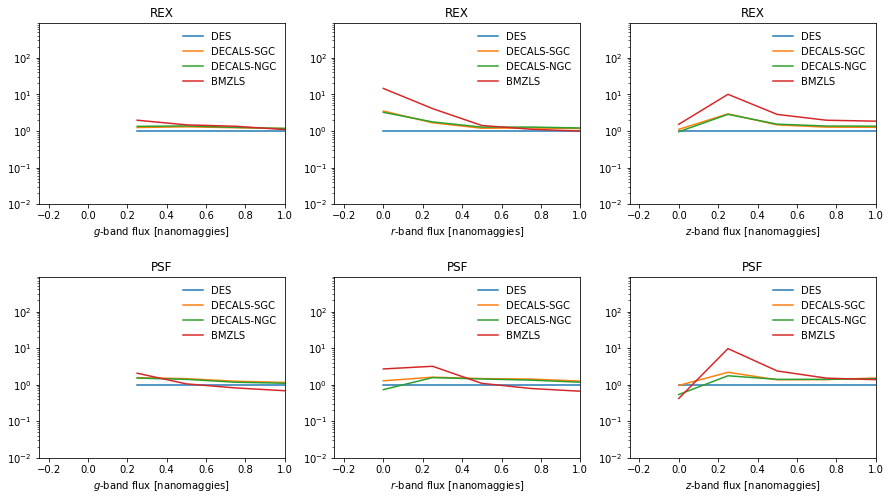

In [377]:
bins          = np.arange(0.0, 10., 0.25) 
fig, ax       = plt.subplots(2, 3, figsize=(15.0, 8.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

for k, mtype in enumerate(['REX', 'PSF']):
  for j, band in enumerate(['G', 'R', 'Z']):
    for i, photsys in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
      cat       = gelgs[gelgs['PHOTSYS'] == photsys]  
      cat       = cat[cat['MORPHTYPE']   == mtype]
    
      afrac     = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))
 
      h, xedges = np.histogram(cat['FLUX_{}'.format(band)] / cat['MW_TRANSMISSION_{}'.format(band)], bins=bins)

      h         = np.array(h) / afrac 
    
      if i == 0:
        norm    = h    
    
      hb        = ax[k][j].semilogy(xedges[:-1], h / norm, label=photsys)  

    ax[k][j].set_xlim(-0.25, 1.0)  
    ax[k][j].set_ylim(0.01, 9.e2)
    ax[k][j].set_xlabel(r'${}$-band flux [nanomaggies]'.format(band.lower()))  
    ax[k][j].set_title(mtype)
    
    ax[k][j].legend(frameon=False)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


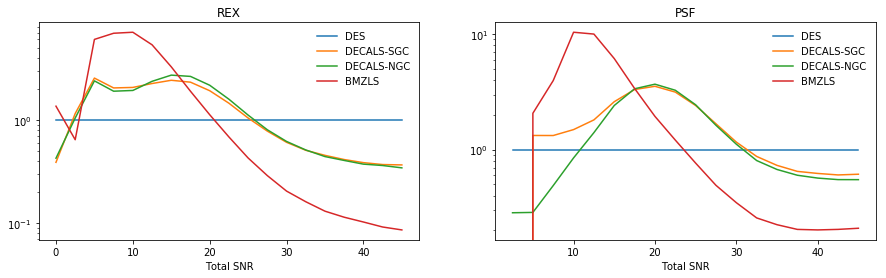

In [416]:
bins            = np.arange(0.0, 50., 2.5) 
fig, ax         = plt.subplots(1, 2, figsize=(15.0, 4.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

for k, mtype in enumerate(['REX', 'PSF']):
  for i, photsys in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
    cat       = gelgs[gelgs['PHOTSYS'] == photsys]  
    cat       = cat[cat['MORPHTYPE']   == mtype]
    
    afrac     = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))

    SNR2      = cat['FLUX_IVAR_G'] * cat['FLUX_G']**2 
    SNR2     += cat['FLUX_IVAR_R'] * cat['FLUX_R']**2
    SNR2     += cat['FLUX_IVAR_Z'] * cat['FLUX_Z']**2
    SNR       = np.sqrt(SNR2) 
        
    h, xedges = np.histogram(SNR, bins=bins)
    h         = np.array(h) / afrac 
        
    if i == 0:
      norm    = h    
    
    hb        = ax[k].semilogy(xedges[:-1], h / norm, label=photsys)  

  ax[k].set_xlabel(r'Total SNR'.format(band.lower()))  
  ax[k].set_title(mtype)
  ax[k].legend(frameon=False)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


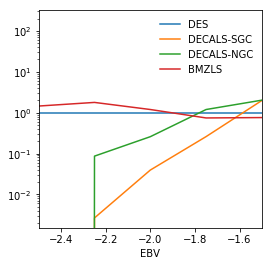

In [461]:
bins        = np.arange(-3., 2., 0.25) 
fig, ax     = plt.subplots(1, 1, figsize=(4.0, 4.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

for i, photsys in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  cat       = gerandoms[gerandoms['PHOTSYS'] == photsys]  
    
  afrac     = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))
        
  h, xedges = np.histogram(np.log10(cat['EBV']), bins=bins)
  h         = np.array(h) / afrac 
        
  if i == 0:
    norm    = h    
    
  hb        = ax.semilogy(xedges[:-1], h / norm, label=photsys)  

ax.set_xlabel(r'EBV'.format(band.lower()))  
ax.set_xlim(-2.5, -1.5)
ax.legend(frameon=False)

In [ ]:
bins        = np.arange(-3., 2., 0.25) 
fig, ax     = plt.subplots(1, 1, figsize=(15.0, 4.0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

for i, photsys in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  cat       = gerandoms[gerandoms['PHOTSYS'] == photsys]  
    
  afrac     = np.mean(np.array(gerandoms['PHOTSYS'] == photsys).astype(np.float))
        
  h, xedges = np.histogram(np.log10(cat['PSF_DEPTH']), bins=bins)
  h         = np.array(h) / afrac 
        
  if i == 0:
    norm    = h    
    
  hb        = ax.semilogy(xedges[:-1], h / norm, label=photsys)  

ax.set_xlabel(r'EBV'.format(band.lower()))  
ax.legend(frameon=False)

Text(0.5,1,'GAIA')

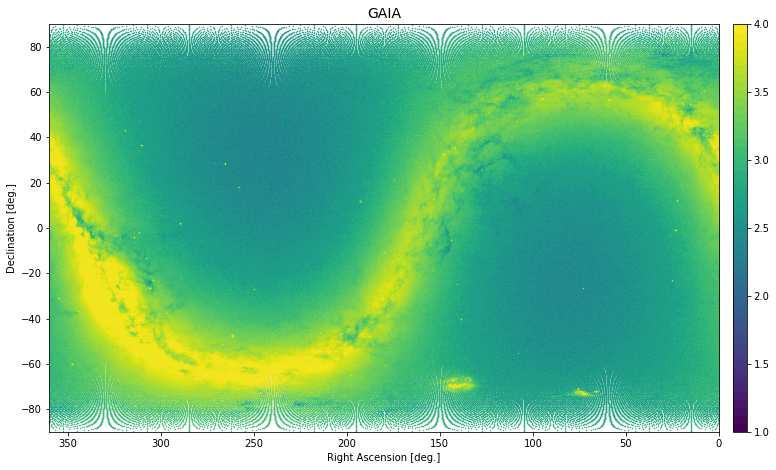

In [247]:
hppix                  = hp.ang2pix(nside, (90. - gaia['DEC']) * np.pi / 180., gaia['RA'] * np.pi / 180., nest=False)
hpind, cnts            = np.unique(hppix, return_counts=True)

nside                  = 256
parea                  = hp.nside2pixarea(nside, degrees = True)

tdensity               = cnts / parea

theta,phi              = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec            = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.]     -= 360.
hpra                  += 60.

fig, ax                = plt.subplots(figsize=(12.5, 7.5))

vmin                   = 1.
vmax                   = 4.

cb                     = fast_scatter(ax, hpra, hpdec, np.log10(tdensity), vmin, vmax, 50, markersize=1.,\
                                      cmap='viridis', printit=False, label=r'')

ax.set_xlim(360.,  0.)
ax.set_ylim(-90., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

ax.set_title('GAIA', fontsize=14)

In [255]:
theta,phi              = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec            = 180. / np.pi * phi, 90. -180. / np.pi * theta

ebv                    = dust.ebv(hpra, hpdec, frame='icrs', equinox='j2000')

Text(0.5,1,'E(B-V)')

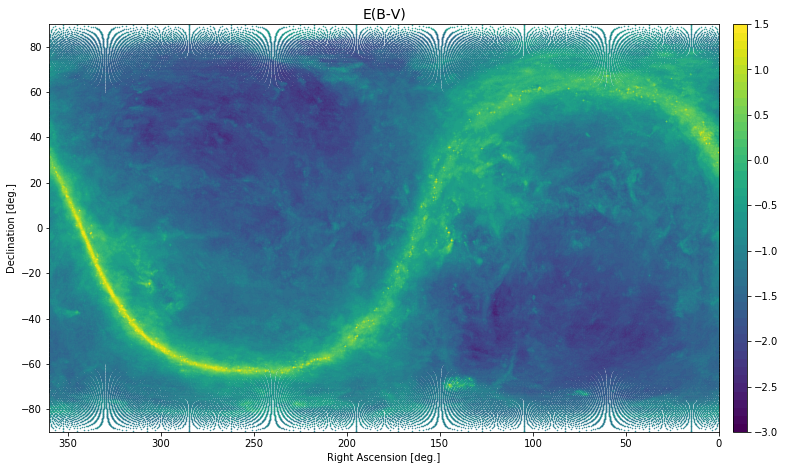

In [256]:
##  Wrap around.  
hpra[hpra > 300.]     -= 360.
hpra                  += 60.

fig, ax                = plt.subplots(figsize=(12.5, 7.5))

vmin                   = -3.
vmax                   =  1.5

cb                     = fast_scatter(ax, hpra, hpdec, np.log10(ebv), vmin, vmax, 50, markersize=1.,\
                                      cmap='viridis', printit=False, label=r'')

ax.set_xlim(360., 0.)
ax.set_ylim(-90., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

ax.set_title('E(B-V)', fontsize=14)

In [279]:
hppix                    = hp.ang2pix(nside, (90. - gerandoms['DEC'][gerandoms['EBV'] < 0.125]) * np.pi / 180., gerandoms['RA'][gerandoms['EBV'] < 0.125] * np.pi / 180., nest=False)
erhpind, ercnts          = np.unique(hppix, return_counts=True)

hppix                    = hp.ang2pix(nside, (90. - gelgs['DEC'][gelgs['EBV'] < 0.125]) * np.pi / 180., gelgs['RA'][gelgs['EBV'] < 0.125] * np.pi / 180., nest=False)
hpind, cnts              = np.unique(hppix, return_counts=True)

erhpind, ercnts          = process_cnts(erhpind, ercnts, printit=False)
hpind,   cnts            = process_cnts(hpind, cnts, printit=False)

tocorrect                = (rcnts > 0) & (ercnts > 0) 
ctdensity                = cnts / parea
ctdensity[ercnts == 0]   = 0.0

ctdensity[tocorrect]     = cnts[tocorrect] / parea / (ercnts[tocorrect] / rcnts[tocorrect]) ##  per sq. deg.

hpind                    = hpind[ctdensity > 0.0]
ctdensity                = ctdensity[ctdensity > 0.0]

array([  19.06364964,   19.06364964,   19.06364964, ..., 6500.7045283 ,
       7129.80496653, 8388.00584297])

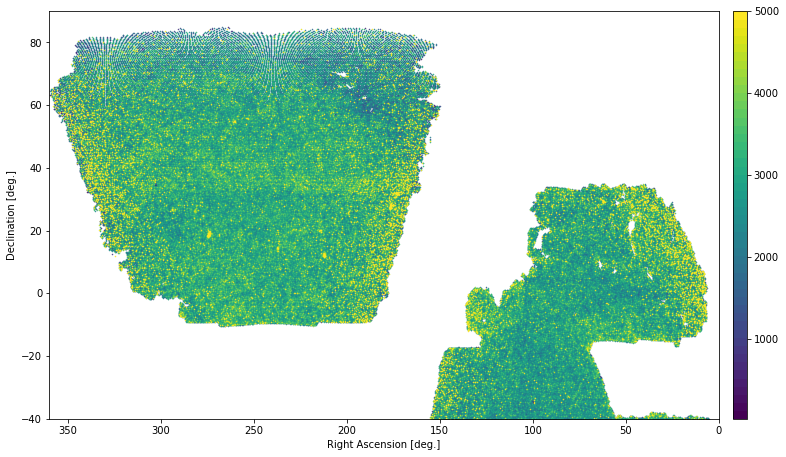

In [280]:
theta,phi                = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec              = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.]       -= 360.
hpra                    += 60.

fig, ax                  = plt.subplots(figsize=(12.5, 7.5))

vmin                     =   20.
vmax                     = 5000.

cb                       = fast_scatter(ax, hpra, hpdec, ctdensity, vmin, vmax, 50, markersize=1.,\
                                        cmap='viridis', printit=False, label=r'')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

np.sort(tdensity)

In [393]:
xcut                   = (gelgs['FLUX_G'] > 0.3)

In [394]:
np.mean(xcut.astype(np.float))

0.9888368689630914

In [395]:
xelgs                  = gelgs[xcut]

In [396]:
hppix                  = hp.ang2pix(nside, (90. - xelgs['DEC']) * np.pi / 180., xelgs['RA'] * np.pi / 180., nest=False)
hpind, cnts            = np.unique(hppix, return_counts=True)

tdensity               = cnts / parea

array([  19.06364964,   19.06364964,   19.06364964, ..., 6500.7045283 ,
       7129.80496653, 8388.00584297])

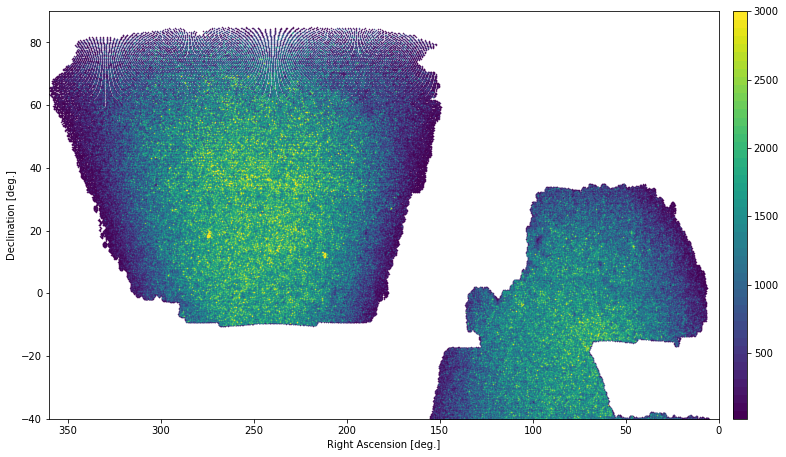

In [397]:
theta,phi              = hp.pix2ang(nside, hpind, nest=False)
hpra, hpdec            = 180. / np.pi * phi, 90. -180. / np.pi * theta

##  Wrap around.  
hpra[hpra > 300.]     -= 360.
hpra                  += 60.

fig, ax                = plt.subplots(figsize=(12.5, 7.5))

vmin                   =   20.
vmax                   = 3000.

cb                     = fast_scatter(ax, hpra, hpdec, tdensity, vmin, vmax, 50, markersize=1.,\
                                      cmap='viridis', printit=False, label=r'')

ax.set_xlim(360., 0.)
ax.set_ylim(-40., 90.)

ax.set_xlabel('Right Ascension [deg.]', fontsize=10)
ax.set_ylabel('Declination [deg.]',     fontsize=10)

np.sort(tdensity)

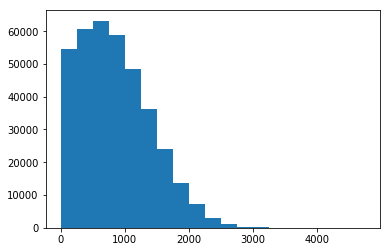

In [398]:
_ = pl.hist(tdensity, bins=np.arange(0.0, 5.e3, 250.))

Solving for BMZLS: EBV
Solving for DECALS-NGC: EBV
Solving for DECALS-SGC: EBV
Solving for DES: EBV


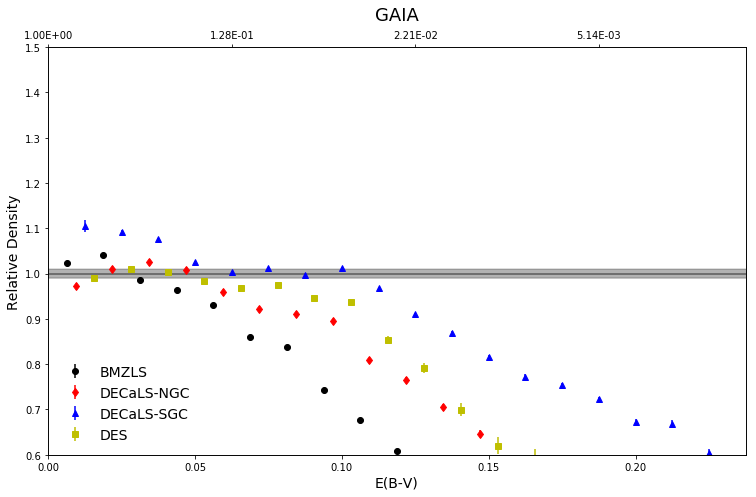

In [399]:
key            = 'EBV'
limit          =  0.25

fig, ax        = plt.subplots(figsize=(12.5, 7.5))
bins           = np.arange(0.0, limit, limit / 20.)
    
taxis          = np.array([np.array(gerandoms[key] >= x, dtype=np.float).sum() / len(gerandoms) for x in bins[::5]])
    
print('Solving for BMZLS: {}'.format(key))
    
helg_bmzls = np.histogram(        xelgs[xelgs['PHOTSYS'] == 'BMZLS'][key], bins=bins)
hran_bmzls = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'BMZLS'][key], bins=bins)
    
print('Solving for DECALS-NGC: {}'.format(key))
        
helg_dclsn = np.histogram(        xelgs[xelgs['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
hran_dclsn = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-NGC'][key], bins=bins)
    
print('Solving for DECALS-SGC: {}'.format(key))
    
helg_dclss = np.histogram(        xelgs[xelgs['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
hran_dclss = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DECALS-SGC'][key], bins=bins)
    
print('Solving for DES: {}'.format(key))
    
helg_des   = np.histogram(        xelgs[xelgs['PHOTSYS'] == 'DES'][key], bins=bins)
hran_des   = np.histogram(gerandoms[gerandoms['PHOTSYS'] == 'DES'][key], bins=bins)
        
plot_rel(helg_bmzls, hran_bmzls, helg_dclsn, hran_dclsn, helg_dclss, hran_dclss, helg_des, hran_des, 'GAIA', r'E(B-V)', taxis=taxis, maxes=None)

In [402]:
for j, survey in enumerate(['DES', 'DECALS-SGC', 'DECALS-NGC', 'BMZLS']):
  afrac        = np.mean(np.array(gerandoms['PHOTSYS'] == survey).astype(np.float))
  types, cnts  = np.unique(np.array(xelgs[xelgs['PHOTSYS'] == survey]['MORPHTYPE']), return_counts=True)
  cnts         = np.concatenate([cnts, np.array([cnts.sum()])])  
  cnts         = cnts / afrac
  
  if j == 0:
    norm       = cnts        
    print('\n' + '\t'.join(types.tolist() + ['Total']))

  ncnts        = np.array(cnts) / np.array(norm)
  ncnts        = ['{:.2f}'.format(x) for x in ncnts]
    
  print('\n{} ({:.3f}, {:.2f})'.format(survey, afrac, np.sum(np.array(cnts) / 1.e6)))
    
  print('\t'.join(ncnts))


COMP	DEV	EXP	PSF	REX	Total

DES (0.268, 31.40)
1.00	1.00	1.00	1.00	1.00	1.00

DECALS-SGC (0.172, 31.38)
0.32	0.56	0.60	1.33	1.19	1.00

DECALS-NGC (0.314, 34.16)
0.28	0.54	0.65	1.33	1.33	1.09

BMZLS (0.246, 35.23)
0.09	0.25	0.20	1.30	1.65	1.12


In [401]:
len(xelgs) / 1.e6

16.602928

# Done